In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install xgboost

In [3]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [6]:
# Load the dataset
all_data = pd.read_csv(r'final_features.csv')

In [5]:
# Load additional features
glove_tags = pd.read_csv(r'alltags_feature.csv')
glove_title = pd.read_csv(r'title_feature.csv')
all_data = pd.concat([all_data, glove_tags, glove_title], axis=1)

In [7]:
# Split the data
train_all_data, submit_all_data = train_test_split(all_data, stratify=all_data['Category'], test_size=0.2, random_state=42)

train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'label', 'mean_label'] 
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

train_label_df = train_all_data[['Pid', 'label']]
train_feature_df = train_all_data.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)

In [7]:
train_label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201036 entries, 0 to 201035
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Pid     201036 non-null  int64  
 1   label   201036 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.1 MB


In [8]:
train_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201036 entries, 0 to 201035
Columns: 669 entries, Uid to title_fe_299
dtypes: float64(645), int64(24)
memory usage: 1.0 GB


In [9]:
# XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.03,
    'max_depth': 8
#     'n_estimators': 10000,
#     'early_stopping_rounds': 500
}

valid_ans = []
submit_proba = []
kfold = KFold(n_splits=5, shuffle=True, random_state=2020)
best_mae = float('inf')
best_model = None
model_save_path = r'C:\Users\sonal\OneDrive\Documents\DATA 255 - Lightgbm\xgboost'

for n, (train_idx, valid_idx) in enumerate(kfold.split(train_feature_df, train_label_df)):
    fold_train_x, fold_train_y = train_feature_df.iloc[train_idx], train_label_df['label'].iloc[train_idx]
    fold_valid_x, fold_valid_y = train_feature_df.iloc[valid_idx], train_label_df['label'].iloc[valid_idx]
    
    xgb_train = xgb.DMatrix(fold_train_x, label=fold_train_y)
    xgb_valid = xgb.DMatrix(fold_valid_x, label=fold_valid_y)
    
    print('Training start')
    
    xgb_model = xgb.train(xgb_params, xgb_train, evals=[(xgb_valid, 'valid')], num_boost_round=10000, early_stopping_rounds=50)
    
    print('Training end')
    
    valid_pred = xgb_model.predict(xgb.DMatrix(fold_valid_x))
    valid_rmse = np.sqrt(mean_squared_error(fold_valid_y, valid_pred))
    valid_mae = mean_absolute_error(fold_valid_y, valid_pred)
    valid_src = stats.spearmanr(fold_valid_y, valid_pred)[0]
    
    print(f"Fold {n}: RMSE: {valid_rmse:.4f}, MAE: {valid_mae:.4f}, SRC: {valid_src:.4f}")
    
    if valid_mae < best_mae:
        best_mae = valid_mae
        best_model = xgb_model
        best_actuals = fold_valid_y
        best_predictions = valid_pred
        # Save the best model
        best_model.save_model(os.path.join(model_save_path, 'best_xgb_model_10000.pkl'))

    valid_ans.append([valid_rmse, valid_mae, valid_src])
        
    submit_pred = xgb_model.predict(xgb.DMatrix(submit_feature_df))
    submit_proba.append(submit_pred)
    
# Calculate mean of the validation answers
valid_ans = np.mean(valid_ans, axis=0)
print(f"Valid: RMSE: {valid_ans[0]:.4f}, MAE: {valid_ans[1]:.4f}, SRC: {valid_ans[2]:.4f}")

# Evaluate performance on test data
submit_actuals = submit_label_df['label']
submit_predictions = best_model.predict(xgb.DMatrix(submit_feature_df))
test_rmse = np.sqrt(mean_squared_error(submit_actuals, submit_predictions))
test_mae = mean_absolute_error(submit_actuals, submit_predictions)
test_src = stats.spearmanr(submit_actuals, submit_predictions)[0]

# Print test metrics
print(f"Test: RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, SRC: {test_src:.4f}")

# Save result to csv
submit_ans = np.mean(submit_proba, axis=0)
result = pd.DataFrame()
result['post_id'] = submit_label_df['Pid'].apply(lambda x: f'post{x}')
result['popularity_score'] = submit_ans.round(decimals=4)

# Save the CSV output, modify the path as needed
result.to_csv(r'C:\Users\sonal\OneDrive\Documents\DATA 255 - Lightgbm\xgboost\KFold_xgboost_results_10000.csv', index=False)

Training start
[0]	valid-mae:1.90112
[1]	valid-mae:1.87261
[2]	valid-mae:1.84554
[3]	valid-mae:1.82010
[4]	valid-mae:1.79455
[5]	valid-mae:1.77071
[6]	valid-mae:1.74617
[7]	valid-mae:1.72294
[8]	valid-mae:1.70095
[9]	valid-mae:1.67928
[10]	valid-mae:1.65750
[11]	valid-mae:1.63673
[12]	valid-mae:1.61677
[13]	valid-mae:1.59834
[14]	valid-mae:1.57925
[15]	valid-mae:1.56113
[16]	valid-mae:1.54284
[17]	valid-mae:1.52569
[18]	valid-mae:1.50905
[19]	valid-mae:1.49250
[20]	valid-mae:1.47729
[21]	valid-mae:1.46261
[22]	valid-mae:1.44820
[23]	valid-mae:1.43354
[24]	valid-mae:1.41939
[25]	valid-mae:1.40606
[26]	valid-mae:1.39311
[27]	valid-mae:1.38089
[28]	valid-mae:1.36845
[29]	valid-mae:1.35659
[30]	valid-mae:1.34474
[31]	valid-mae:1.33330
[32]	valid-mae:1.32203
[33]	valid-mae:1.31139
[34]	valid-mae:1.30048
[35]	valid-mae:1.29011
[36]	valid-mae:1.28025
[37]	valid-mae:1.27055
[38]	valid-mae:1.26135
[39]	valid-mae:1.25235
[40]	valid-mae:1.24388
[41]	valid-mae:1.23566
[42]	valid-mae:1.22708
[43]	v

[346]	valid-mae:0.75165
[347]	valid-mae:0.75135
[348]	valid-mae:0.75078
[349]	valid-mae:0.75065
[350]	valid-mae:0.75032
[351]	valid-mae:0.74977
[352]	valid-mae:0.74927
[353]	valid-mae:0.74876
[354]	valid-mae:0.74811
[355]	valid-mae:0.74781
[356]	valid-mae:0.74739
[357]	valid-mae:0.74688
[358]	valid-mae:0.74645
[359]	valid-mae:0.74601
[360]	valid-mae:0.74561
[361]	valid-mae:0.74523
[362]	valid-mae:0.74487
[363]	valid-mae:0.74443
[364]	valid-mae:0.74394
[365]	valid-mae:0.74360
[366]	valid-mae:0.74317
[367]	valid-mae:0.74294
[368]	valid-mae:0.74282
[369]	valid-mae:0.74258
[370]	valid-mae:0.74201
[371]	valid-mae:0.74173
[372]	valid-mae:0.74155
[373]	valid-mae:0.74101
[374]	valid-mae:0.74078
[375]	valid-mae:0.74064
[376]	valid-mae:0.74016
[377]	valid-mae:0.73985
[378]	valid-mae:0.73934
[379]	valid-mae:0.73917
[380]	valid-mae:0.73859
[381]	valid-mae:0.73811
[382]	valid-mae:0.73784
[383]	valid-mae:0.73738
[384]	valid-mae:0.73713
[385]	valid-mae:0.73702
[386]	valid-mae:0.73665
[387]	valid-mae:

[688]	valid-mae:0.66909
[689]	valid-mae:0.66897
[690]	valid-mae:0.66887
[691]	valid-mae:0.66869
[692]	valid-mae:0.66856
[693]	valid-mae:0.66838
[694]	valid-mae:0.66819
[695]	valid-mae:0.66807
[696]	valid-mae:0.66797
[697]	valid-mae:0.66786
[698]	valid-mae:0.66774
[699]	valid-mae:0.66754
[700]	valid-mae:0.66744
[701]	valid-mae:0.66738
[702]	valid-mae:0.66727
[703]	valid-mae:0.66710
[704]	valid-mae:0.66683
[705]	valid-mae:0.66669
[706]	valid-mae:0.66658
[707]	valid-mae:0.66644
[708]	valid-mae:0.66639
[709]	valid-mae:0.66630
[710]	valid-mae:0.66620
[711]	valid-mae:0.66599
[712]	valid-mae:0.66588
[713]	valid-mae:0.66576
[714]	valid-mae:0.66569
[715]	valid-mae:0.66554
[716]	valid-mae:0.66538
[717]	valid-mae:0.66515
[718]	valid-mae:0.66505
[719]	valid-mae:0.66502
[720]	valid-mae:0.66496
[721]	valid-mae:0.66491
[722]	valid-mae:0.66486
[723]	valid-mae:0.66463
[724]	valid-mae:0.66454
[725]	valid-mae:0.66449
[726]	valid-mae:0.66429
[727]	valid-mae:0.66415
[728]	valid-mae:0.66396
[729]	valid-mae:

[1029]	valid-mae:0.63372
[1030]	valid-mae:0.63366
[1031]	valid-mae:0.63358
[1032]	valid-mae:0.63355
[1033]	valid-mae:0.63345
[1034]	valid-mae:0.63342
[1035]	valid-mae:0.63332
[1036]	valid-mae:0.63323
[1037]	valid-mae:0.63315
[1038]	valid-mae:0.63308
[1039]	valid-mae:0.63295
[1040]	valid-mae:0.63285
[1041]	valid-mae:0.63277
[1042]	valid-mae:0.63270
[1043]	valid-mae:0.63261
[1044]	valid-mae:0.63257
[1045]	valid-mae:0.63251
[1046]	valid-mae:0.63247
[1047]	valid-mae:0.63242
[1048]	valid-mae:0.63232
[1049]	valid-mae:0.63222
[1050]	valid-mae:0.63216
[1051]	valid-mae:0.63211
[1052]	valid-mae:0.63201
[1053]	valid-mae:0.63191
[1054]	valid-mae:0.63180
[1055]	valid-mae:0.63170
[1056]	valid-mae:0.63163
[1057]	valid-mae:0.63158
[1058]	valid-mae:0.63151
[1059]	valid-mae:0.63145
[1060]	valid-mae:0.63142
[1061]	valid-mae:0.63136
[1062]	valid-mae:0.63130
[1063]	valid-mae:0.63121
[1064]	valid-mae:0.63113
[1065]	valid-mae:0.63104
[1066]	valid-mae:0.63100
[1067]	valid-mae:0.63090
[1068]	valid-mae:0.63081


[1357]	valid-mae:0.61303
[1358]	valid-mae:0.61295
[1359]	valid-mae:0.61288
[1360]	valid-mae:0.61280
[1361]	valid-mae:0.61271
[1362]	valid-mae:0.61266
[1363]	valid-mae:0.61264
[1364]	valid-mae:0.61262
[1365]	valid-mae:0.61258
[1366]	valid-mae:0.61255
[1367]	valid-mae:0.61244
[1368]	valid-mae:0.61236
[1369]	valid-mae:0.61229
[1370]	valid-mae:0.61227
[1371]	valid-mae:0.61222
[1372]	valid-mae:0.61218
[1373]	valid-mae:0.61211
[1374]	valid-mae:0.61203
[1375]	valid-mae:0.61198
[1376]	valid-mae:0.61193
[1377]	valid-mae:0.61184
[1378]	valid-mae:0.61180
[1379]	valid-mae:0.61178
[1380]	valid-mae:0.61174
[1381]	valid-mae:0.61168
[1382]	valid-mae:0.61167
[1383]	valid-mae:0.61163
[1384]	valid-mae:0.61156
[1385]	valid-mae:0.61154
[1386]	valid-mae:0.61149
[1387]	valid-mae:0.61144
[1388]	valid-mae:0.61137
[1389]	valid-mae:0.61135
[1390]	valid-mae:0.61126
[1391]	valid-mae:0.61123
[1392]	valid-mae:0.61121
[1393]	valid-mae:0.61118
[1394]	valid-mae:0.61109
[1395]	valid-mae:0.61104
[1396]	valid-mae:0.61099


[1685]	valid-mae:0.59936
[1686]	valid-mae:0.59934
[1687]	valid-mae:0.59930
[1688]	valid-mae:0.59925
[1689]	valid-mae:0.59923
[1690]	valid-mae:0.59922
[1691]	valid-mae:0.59917
[1692]	valid-mae:0.59916
[1693]	valid-mae:0.59915
[1694]	valid-mae:0.59913
[1695]	valid-mae:0.59908
[1696]	valid-mae:0.59904
[1697]	valid-mae:0.59901
[1698]	valid-mae:0.59896
[1699]	valid-mae:0.59893
[1700]	valid-mae:0.59893
[1701]	valid-mae:0.59889
[1702]	valid-mae:0.59886
[1703]	valid-mae:0.59883
[1704]	valid-mae:0.59880
[1705]	valid-mae:0.59876
[1706]	valid-mae:0.59873
[1707]	valid-mae:0.59867
[1708]	valid-mae:0.59865
[1709]	valid-mae:0.59862
[1710]	valid-mae:0.59859
[1711]	valid-mae:0.59856
[1712]	valid-mae:0.59853
[1713]	valid-mae:0.59850
[1714]	valid-mae:0.59848
[1715]	valid-mae:0.59846
[1716]	valid-mae:0.59845
[1717]	valid-mae:0.59841
[1718]	valid-mae:0.59837
[1719]	valid-mae:0.59836
[1720]	valid-mae:0.59833
[1721]	valid-mae:0.59829
[1722]	valid-mae:0.59826
[1723]	valid-mae:0.59823
[1724]	valid-mae:0.59819


[2013]	valid-mae:0.59023
[2014]	valid-mae:0.59019
[2015]	valid-mae:0.59018
[2016]	valid-mae:0.59016
[2017]	valid-mae:0.59011
[2018]	valid-mae:0.59008
[2019]	valid-mae:0.59006
[2020]	valid-mae:0.59005
[2021]	valid-mae:0.59003
[2022]	valid-mae:0.59001
[2023]	valid-mae:0.59000
[2024]	valid-mae:0.58998
[2025]	valid-mae:0.58995
[2026]	valid-mae:0.58992
[2027]	valid-mae:0.58992
[2028]	valid-mae:0.58989
[2029]	valid-mae:0.58985
[2030]	valid-mae:0.58985
[2031]	valid-mae:0.58983
[2032]	valid-mae:0.58981
[2033]	valid-mae:0.58981
[2034]	valid-mae:0.58976
[2035]	valid-mae:0.58971
[2036]	valid-mae:0.58969
[2037]	valid-mae:0.58966
[2038]	valid-mae:0.58964
[2039]	valid-mae:0.58962
[2040]	valid-mae:0.58961
[2041]	valid-mae:0.58959
[2042]	valid-mae:0.58956
[2043]	valid-mae:0.58954
[2044]	valid-mae:0.58952
[2045]	valid-mae:0.58949
[2046]	valid-mae:0.58948
[2047]	valid-mae:0.58946
[2048]	valid-mae:0.58944
[2049]	valid-mae:0.58943
[2050]	valid-mae:0.58942
[2051]	valid-mae:0.58939
[2052]	valid-mae:0.58938


[2341]	valid-mae:0.58374
[2342]	valid-mae:0.58373
[2343]	valid-mae:0.58371
[2344]	valid-mae:0.58368
[2345]	valid-mae:0.58367
[2346]	valid-mae:0.58365
[2347]	valid-mae:0.58363
[2348]	valid-mae:0.58361
[2349]	valid-mae:0.58360
[2350]	valid-mae:0.58356
[2351]	valid-mae:0.58353
[2352]	valid-mae:0.58352
[2353]	valid-mae:0.58352
[2354]	valid-mae:0.58351
[2355]	valid-mae:0.58350
[2356]	valid-mae:0.58348
[2357]	valid-mae:0.58346
[2358]	valid-mae:0.58344
[2359]	valid-mae:0.58343
[2360]	valid-mae:0.58342
[2361]	valid-mae:0.58340
[2362]	valid-mae:0.58338
[2363]	valid-mae:0.58335
[2364]	valid-mae:0.58334
[2365]	valid-mae:0.58333
[2366]	valid-mae:0.58330
[2367]	valid-mae:0.58326
[2368]	valid-mae:0.58324
[2369]	valid-mae:0.58322
[2370]	valid-mae:0.58319
[2371]	valid-mae:0.58318
[2372]	valid-mae:0.58316
[2373]	valid-mae:0.58316
[2374]	valid-mae:0.58313
[2375]	valid-mae:0.58313
[2376]	valid-mae:0.58311
[2377]	valid-mae:0.58309
[2378]	valid-mae:0.58307
[2379]	valid-mae:0.58306
[2380]	valid-mae:0.58303


[2669]	valid-mae:0.57872
[2670]	valid-mae:0.57871
[2671]	valid-mae:0.57869
[2672]	valid-mae:0.57868
[2673]	valid-mae:0.57868
[2674]	valid-mae:0.57866
[2675]	valid-mae:0.57865
[2676]	valid-mae:0.57863
[2677]	valid-mae:0.57863
[2678]	valid-mae:0.57860
[2679]	valid-mae:0.57859
[2680]	valid-mae:0.57857
[2681]	valid-mae:0.57857
[2682]	valid-mae:0.57856
[2683]	valid-mae:0.57854
[2684]	valid-mae:0.57853
[2685]	valid-mae:0.57851
[2686]	valid-mae:0.57850
[2687]	valid-mae:0.57847
[2688]	valid-mae:0.57846
[2689]	valid-mae:0.57844
[2690]	valid-mae:0.57844
[2691]	valid-mae:0.57842
[2692]	valid-mae:0.57841
[2693]	valid-mae:0.57840
[2694]	valid-mae:0.57840
[2695]	valid-mae:0.57839
[2696]	valid-mae:0.57837
[2697]	valid-mae:0.57836
[2698]	valid-mae:0.57835
[2699]	valid-mae:0.57834
[2700]	valid-mae:0.57834
[2701]	valid-mae:0.57833
[2702]	valid-mae:0.57832
[2703]	valid-mae:0.57830
[2704]	valid-mae:0.57829
[2705]	valid-mae:0.57828
[2706]	valid-mae:0.57828
[2707]	valid-mae:0.57827
[2708]	valid-mae:0.57826


[2997]	valid-mae:0.57511
[2998]	valid-mae:0.57509
[2999]	valid-mae:0.57509
[3000]	valid-mae:0.57508
[3001]	valid-mae:0.57508
[3002]	valid-mae:0.57507
[3003]	valid-mae:0.57507
[3004]	valid-mae:0.57506
[3005]	valid-mae:0.57504
[3006]	valid-mae:0.57503
[3007]	valid-mae:0.57502
[3008]	valid-mae:0.57502
[3009]	valid-mae:0.57501
[3010]	valid-mae:0.57499
[3011]	valid-mae:0.57499
[3012]	valid-mae:0.57498
[3013]	valid-mae:0.57496
[3014]	valid-mae:0.57496
[3015]	valid-mae:0.57495
[3016]	valid-mae:0.57493
[3017]	valid-mae:0.57492
[3018]	valid-mae:0.57491
[3019]	valid-mae:0.57490
[3020]	valid-mae:0.57488
[3021]	valid-mae:0.57487
[3022]	valid-mae:0.57487
[3023]	valid-mae:0.57486
[3024]	valid-mae:0.57486
[3025]	valid-mae:0.57485
[3026]	valid-mae:0.57486
[3027]	valid-mae:0.57484
[3028]	valid-mae:0.57482
[3029]	valid-mae:0.57481
[3030]	valid-mae:0.57480
[3031]	valid-mae:0.57479
[3032]	valid-mae:0.57479
[3033]	valid-mae:0.57477
[3034]	valid-mae:0.57477
[3035]	valid-mae:0.57476
[3036]	valid-mae:0.57475


[3325]	valid-mae:0.57221
[3326]	valid-mae:0.57221
[3327]	valid-mae:0.57220
[3328]	valid-mae:0.57219
[3329]	valid-mae:0.57217
[3330]	valid-mae:0.57217
[3331]	valid-mae:0.57215
[3332]	valid-mae:0.57214
[3333]	valid-mae:0.57214
[3334]	valid-mae:0.57212
[3335]	valid-mae:0.57211
[3336]	valid-mae:0.57211
[3337]	valid-mae:0.57210
[3338]	valid-mae:0.57209
[3339]	valid-mae:0.57208
[3340]	valid-mae:0.57208
[3341]	valid-mae:0.57208
[3342]	valid-mae:0.57206
[3343]	valid-mae:0.57205
[3344]	valid-mae:0.57205
[3345]	valid-mae:0.57203
[3346]	valid-mae:0.57203
[3347]	valid-mae:0.57203
[3348]	valid-mae:0.57201
[3349]	valid-mae:0.57201
[3350]	valid-mae:0.57200
[3351]	valid-mae:0.57199
[3352]	valid-mae:0.57198
[3353]	valid-mae:0.57197
[3354]	valid-mae:0.57197
[3355]	valid-mae:0.57196
[3356]	valid-mae:0.57196
[3357]	valid-mae:0.57194
[3358]	valid-mae:0.57193
[3359]	valid-mae:0.57193
[3360]	valid-mae:0.57192
[3361]	valid-mae:0.57192
[3362]	valid-mae:0.57192
[3363]	valid-mae:0.57191
[3364]	valid-mae:0.57190


[3653]	valid-mae:0.56988
[3654]	valid-mae:0.56988
[3655]	valid-mae:0.56987
[3656]	valid-mae:0.56987
[3657]	valid-mae:0.56986
[3658]	valid-mae:0.56985
[3659]	valid-mae:0.56985
[3660]	valid-mae:0.56984
[3661]	valid-mae:0.56983
[3662]	valid-mae:0.56983
[3663]	valid-mae:0.56983
[3664]	valid-mae:0.56982
[3665]	valid-mae:0.56982
[3666]	valid-mae:0.56981
[3667]	valid-mae:0.56979
[3668]	valid-mae:0.56979
[3669]	valid-mae:0.56978
[3670]	valid-mae:0.56978
[3671]	valid-mae:0.56977
[3672]	valid-mae:0.56976
[3673]	valid-mae:0.56976
[3674]	valid-mae:0.56975
[3675]	valid-mae:0.56974
[3676]	valid-mae:0.56974
[3677]	valid-mae:0.56973
[3678]	valid-mae:0.56973
[3679]	valid-mae:0.56972
[3680]	valid-mae:0.56971
[3681]	valid-mae:0.56970
[3682]	valid-mae:0.56970
[3683]	valid-mae:0.56969
[3684]	valid-mae:0.56968
[3685]	valid-mae:0.56967
[3686]	valid-mae:0.56967
[3687]	valid-mae:0.56966
[3688]	valid-mae:0.56965
[3689]	valid-mae:0.56965
[3690]	valid-mae:0.56964
[3691]	valid-mae:0.56963
[3692]	valid-mae:0.56963


[3981]	valid-mae:0.56810
[3982]	valid-mae:0.56809
[3983]	valid-mae:0.56808
[3984]	valid-mae:0.56808
[3985]	valid-mae:0.56807
[3986]	valid-mae:0.56806
[3987]	valid-mae:0.56805
[3988]	valid-mae:0.56804
[3989]	valid-mae:0.56804
[3990]	valid-mae:0.56804
[3991]	valid-mae:0.56803
[3992]	valid-mae:0.56802
[3993]	valid-mae:0.56801
[3994]	valid-mae:0.56800
[3995]	valid-mae:0.56800
[3996]	valid-mae:0.56799
[3997]	valid-mae:0.56799
[3998]	valid-mae:0.56798
[3999]	valid-mae:0.56797
[4000]	valid-mae:0.56797
[4001]	valid-mae:0.56796
[4002]	valid-mae:0.56796
[4003]	valid-mae:0.56795
[4004]	valid-mae:0.56794
[4005]	valid-mae:0.56794
[4006]	valid-mae:0.56794
[4007]	valid-mae:0.56792
[4008]	valid-mae:0.56792
[4009]	valid-mae:0.56791
[4010]	valid-mae:0.56791
[4011]	valid-mae:0.56791
[4012]	valid-mae:0.56791
[4013]	valid-mae:0.56790
[4014]	valid-mae:0.56790
[4015]	valid-mae:0.56790
[4016]	valid-mae:0.56789
[4017]	valid-mae:0.56789
[4018]	valid-mae:0.56788
[4019]	valid-mae:0.56787
[4020]	valid-mae:0.56787


[4309]	valid-mae:0.56668
[4310]	valid-mae:0.56667
[4311]	valid-mae:0.56667
[4312]	valid-mae:0.56667
[4313]	valid-mae:0.56666
[4314]	valid-mae:0.56666
[4315]	valid-mae:0.56666
[4316]	valid-mae:0.56666
[4317]	valid-mae:0.56666
[4318]	valid-mae:0.56666
[4319]	valid-mae:0.56665
[4320]	valid-mae:0.56664
[4321]	valid-mae:0.56664
[4322]	valid-mae:0.56664
[4323]	valid-mae:0.56664
[4324]	valid-mae:0.56663
[4325]	valid-mae:0.56663
[4326]	valid-mae:0.56662
[4327]	valid-mae:0.56662
[4328]	valid-mae:0.56662
[4329]	valid-mae:0.56660
[4330]	valid-mae:0.56660
[4331]	valid-mae:0.56659
[4332]	valid-mae:0.56659
[4333]	valid-mae:0.56658
[4334]	valid-mae:0.56659
[4335]	valid-mae:0.56658
[4336]	valid-mae:0.56658
[4337]	valid-mae:0.56658
[4338]	valid-mae:0.56657
[4339]	valid-mae:0.56657
[4340]	valid-mae:0.56656
[4341]	valid-mae:0.56657
[4342]	valid-mae:0.56656
[4343]	valid-mae:0.56656
[4344]	valid-mae:0.56656
[4345]	valid-mae:0.56655
[4346]	valid-mae:0.56655
[4347]	valid-mae:0.56654
[4348]	valid-mae:0.56653


[4637]	valid-mae:0.56538
[4638]	valid-mae:0.56538
[4639]	valid-mae:0.56538
[4640]	valid-mae:0.56537
[4641]	valid-mae:0.56537
[4642]	valid-mae:0.56537
[4643]	valid-mae:0.56536
[4644]	valid-mae:0.56536
[4645]	valid-mae:0.56536
[4646]	valid-mae:0.56536
[4647]	valid-mae:0.56536
[4648]	valid-mae:0.56535
[4649]	valid-mae:0.56535
[4650]	valid-mae:0.56535
[4651]	valid-mae:0.56535
[4652]	valid-mae:0.56534
[4653]	valid-mae:0.56535
[4654]	valid-mae:0.56534
[4655]	valid-mae:0.56534
[4656]	valid-mae:0.56534
[4657]	valid-mae:0.56533
[4658]	valid-mae:0.56533
[4659]	valid-mae:0.56532
[4660]	valid-mae:0.56531
[4661]	valid-mae:0.56531
[4662]	valid-mae:0.56531
[4663]	valid-mae:0.56531
[4664]	valid-mae:0.56530
[4665]	valid-mae:0.56530
[4666]	valid-mae:0.56529
[4667]	valid-mae:0.56529
[4668]	valid-mae:0.56528
[4669]	valid-mae:0.56528
[4670]	valid-mae:0.56527
[4671]	valid-mae:0.56527
[4672]	valid-mae:0.56527
[4673]	valid-mae:0.56527
[4674]	valid-mae:0.56527
[4675]	valid-mae:0.56527
[4676]	valid-mae:0.56526


[4965]	valid-mae:0.56439
[4966]	valid-mae:0.56438
[4967]	valid-mae:0.56438
[4968]	valid-mae:0.56438
[4969]	valid-mae:0.56438
[4970]	valid-mae:0.56438
[4971]	valid-mae:0.56438
[4972]	valid-mae:0.56437
[4973]	valid-mae:0.56437
[4974]	valid-mae:0.56436
[4975]	valid-mae:0.56436
[4976]	valid-mae:0.56436
[4977]	valid-mae:0.56436
[4978]	valid-mae:0.56435
[4979]	valid-mae:0.56435
[4980]	valid-mae:0.56435
[4981]	valid-mae:0.56435
[4982]	valid-mae:0.56434
[4983]	valid-mae:0.56434
[4984]	valid-mae:0.56434
[4985]	valid-mae:0.56433
[4986]	valid-mae:0.56433
[4987]	valid-mae:0.56433
[4988]	valid-mae:0.56433
[4989]	valid-mae:0.56432
[4990]	valid-mae:0.56431
[4991]	valid-mae:0.56432
[4992]	valid-mae:0.56431
[4993]	valid-mae:0.56430
[4994]	valid-mae:0.56430
[4995]	valid-mae:0.56429
[4996]	valid-mae:0.56429
[4997]	valid-mae:0.56429
[4998]	valid-mae:0.56429
[4999]	valid-mae:0.56429
[5000]	valid-mae:0.56429
[5001]	valid-mae:0.56429
[5002]	valid-mae:0.56428
[5003]	valid-mae:0.56428
[5004]	valid-mae:0.56428


[5293]	valid-mae:0.56374
[5294]	valid-mae:0.56374
[5295]	valid-mae:0.56374
[5296]	valid-mae:0.56374
[5297]	valid-mae:0.56374
[5298]	valid-mae:0.56374
[5299]	valid-mae:0.56373
[5300]	valid-mae:0.56373
[5301]	valid-mae:0.56373
[5302]	valid-mae:0.56373
[5303]	valid-mae:0.56373
[5304]	valid-mae:0.56373
[5305]	valid-mae:0.56373
[5306]	valid-mae:0.56373
[5307]	valid-mae:0.56373
[5308]	valid-mae:0.56373
[5309]	valid-mae:0.56373
[5310]	valid-mae:0.56373
[5311]	valid-mae:0.56373
[5312]	valid-mae:0.56373
[5313]	valid-mae:0.56373
[5314]	valid-mae:0.56373
[5315]	valid-mae:0.56373
[5316]	valid-mae:0.56373
[5317]	valid-mae:0.56373
[5318]	valid-mae:0.56373
[5319]	valid-mae:0.56372
[5320]	valid-mae:0.56372
[5321]	valid-mae:0.56371
[5322]	valid-mae:0.56371
[5323]	valid-mae:0.56371
[5324]	valid-mae:0.56371
[5325]	valid-mae:0.56371
[5326]	valid-mae:0.56370
[5327]	valid-mae:0.56370
[5328]	valid-mae:0.56370
[5329]	valid-mae:0.56369
[5330]	valid-mae:0.56369
[5331]	valid-mae:0.56369
[5332]	valid-mae:0.56369


[5621]	valid-mae:0.56317
[5622]	valid-mae:0.56317
[5623]	valid-mae:0.56317
[5624]	valid-mae:0.56316
[5625]	valid-mae:0.56316
[5626]	valid-mae:0.56316
[5627]	valid-mae:0.56315
[5628]	valid-mae:0.56315
[5629]	valid-mae:0.56315
[5630]	valid-mae:0.56314
[5631]	valid-mae:0.56314
[5632]	valid-mae:0.56313
[5633]	valid-mae:0.56313
[5634]	valid-mae:0.56312
[5635]	valid-mae:0.56312
[5636]	valid-mae:0.56312
[5637]	valid-mae:0.56312
[5638]	valid-mae:0.56312
[5639]	valid-mae:0.56312
[5640]	valid-mae:0.56312
[5641]	valid-mae:0.56312
[5642]	valid-mae:0.56311
[5643]	valid-mae:0.56311
[5644]	valid-mae:0.56311
[5645]	valid-mae:0.56311
[5646]	valid-mae:0.56311
[5647]	valid-mae:0.56311
[5648]	valid-mae:0.56311
[5649]	valid-mae:0.56310
[5650]	valid-mae:0.56310
[5651]	valid-mae:0.56310
[5652]	valid-mae:0.56310
[5653]	valid-mae:0.56310
[5654]	valid-mae:0.56309
[5655]	valid-mae:0.56309
[5656]	valid-mae:0.56310
[5657]	valid-mae:0.56310
[5658]	valid-mae:0.56309
[5659]	valid-mae:0.56309
[5660]	valid-mae:0.56309


[5949]	valid-mae:0.56264
[5950]	valid-mae:0.56264
[5951]	valid-mae:0.56264
[5952]	valid-mae:0.56264
[5953]	valid-mae:0.56264
[5954]	valid-mae:0.56264
[5955]	valid-mae:0.56264
[5956]	valid-mae:0.56264
[5957]	valid-mae:0.56264
[5958]	valid-mae:0.56264
[5959]	valid-mae:0.56264
[5960]	valid-mae:0.56263
[5961]	valid-mae:0.56263
[5962]	valid-mae:0.56263
[5963]	valid-mae:0.56263
[5964]	valid-mae:0.56263
[5965]	valid-mae:0.56263
[5966]	valid-mae:0.56263
[5967]	valid-mae:0.56263
[5968]	valid-mae:0.56263
[5969]	valid-mae:0.56264
[5970]	valid-mae:0.56264
[5971]	valid-mae:0.56264
[5972]	valid-mae:0.56264
[5973]	valid-mae:0.56263
[5974]	valid-mae:0.56263
[5975]	valid-mae:0.56263
[5976]	valid-mae:0.56263
[5977]	valid-mae:0.56263
[5978]	valid-mae:0.56263
[5979]	valid-mae:0.56263
[5980]	valid-mae:0.56263
[5981]	valid-mae:0.56263
[5982]	valid-mae:0.56263
[5983]	valid-mae:0.56262
[5984]	valid-mae:0.56262
[5985]	valid-mae:0.56262
[5986]	valid-mae:0.56262
[5987]	valid-mae:0.56262
[5988]	valid-mae:0.56262


[6277]	valid-mae:0.56226
[6278]	valid-mae:0.56226
[6279]	valid-mae:0.56226
[6280]	valid-mae:0.56225
[6281]	valid-mae:0.56226
[6282]	valid-mae:0.56225
[6283]	valid-mae:0.56226
[6284]	valid-mae:0.56226
[6285]	valid-mae:0.56225
[6286]	valid-mae:0.56225
[6287]	valid-mae:0.56225
[6288]	valid-mae:0.56225
[6289]	valid-mae:0.56225
[6290]	valid-mae:0.56225
[6291]	valid-mae:0.56224
[6292]	valid-mae:0.56224
[6293]	valid-mae:0.56224
[6294]	valid-mae:0.56224
[6295]	valid-mae:0.56224
[6296]	valid-mae:0.56224
[6297]	valid-mae:0.56224
[6298]	valid-mae:0.56223
[6299]	valid-mae:0.56223
[6300]	valid-mae:0.56223
[6301]	valid-mae:0.56223
[6302]	valid-mae:0.56223
[6303]	valid-mae:0.56222
[6304]	valid-mae:0.56222
[6305]	valid-mae:0.56222
[6306]	valid-mae:0.56222
[6307]	valid-mae:0.56222
[6308]	valid-mae:0.56221
[6309]	valid-mae:0.56221
[6310]	valid-mae:0.56221
[6311]	valid-mae:0.56221
[6312]	valid-mae:0.56221
[6313]	valid-mae:0.56221
[6314]	valid-mae:0.56221
[6315]	valid-mae:0.56220
[6316]	valid-mae:0.56220


[6605]	valid-mae:0.56201
[6606]	valid-mae:0.56201
[6607]	valid-mae:0.56201
[6608]	valid-mae:0.56201
[6609]	valid-mae:0.56201
[6610]	valid-mae:0.56201
[6611]	valid-mae:0.56200
[6612]	valid-mae:0.56201
[6613]	valid-mae:0.56201
[6614]	valid-mae:0.56201
[6615]	valid-mae:0.56201
[6616]	valid-mae:0.56201
[6617]	valid-mae:0.56200
[6618]	valid-mae:0.56200
[6619]	valid-mae:0.56200
[6620]	valid-mae:0.56200
[6621]	valid-mae:0.56200
[6622]	valid-mae:0.56200
[6623]	valid-mae:0.56200
[6624]	valid-mae:0.56200
[6625]	valid-mae:0.56200
[6626]	valid-mae:0.56200
[6627]	valid-mae:0.56200
[6628]	valid-mae:0.56200
[6629]	valid-mae:0.56199
[6630]	valid-mae:0.56199
[6631]	valid-mae:0.56199
[6632]	valid-mae:0.56199
[6633]	valid-mae:0.56199
[6634]	valid-mae:0.56199
[6635]	valid-mae:0.56199
[6636]	valid-mae:0.56198
[6637]	valid-mae:0.56199
[6638]	valid-mae:0.56199
[6639]	valid-mae:0.56199
[6640]	valid-mae:0.56199
[6641]	valid-mae:0.56199
[6642]	valid-mae:0.56199
[6643]	valid-mae:0.56199
[6644]	valid-mae:0.56198


[6933]	valid-mae:0.56174
[6934]	valid-mae:0.56173
[6935]	valid-mae:0.56173
[6936]	valid-mae:0.56174
[6937]	valid-mae:0.56174
[6938]	valid-mae:0.56173
[6939]	valid-mae:0.56173
[6940]	valid-mae:0.56173
[6941]	valid-mae:0.56173
[6942]	valid-mae:0.56173
[6943]	valid-mae:0.56173
[6944]	valid-mae:0.56173
[6945]	valid-mae:0.56173
[6946]	valid-mae:0.56173
[6947]	valid-mae:0.56173
[6948]	valid-mae:0.56173
[6949]	valid-mae:0.56173
[6950]	valid-mae:0.56173
[6951]	valid-mae:0.56173
[6952]	valid-mae:0.56173
[6953]	valid-mae:0.56173
[6954]	valid-mae:0.56173
[6955]	valid-mae:0.56172
[6956]	valid-mae:0.56173
[6957]	valid-mae:0.56173
[6958]	valid-mae:0.56172
[6959]	valid-mae:0.56173
[6960]	valid-mae:0.56173
[6961]	valid-mae:0.56172
[6962]	valid-mae:0.56172
[6963]	valid-mae:0.56172
[6964]	valid-mae:0.56172
[6965]	valid-mae:0.56172
[6966]	valid-mae:0.56172
[6967]	valid-mae:0.56172
[6968]	valid-mae:0.56172
[6969]	valid-mae:0.56172
[6970]	valid-mae:0.56172
[6971]	valid-mae:0.56172
[6972]	valid-mae:0.56172


[7261]	valid-mae:0.56154
[7262]	valid-mae:0.56154
[7263]	valid-mae:0.56154
[7264]	valid-mae:0.56154
[7265]	valid-mae:0.56154
[7266]	valid-mae:0.56154
[7267]	valid-mae:0.56154
[7268]	valid-mae:0.56154
[7269]	valid-mae:0.56154
[7270]	valid-mae:0.56154
[7271]	valid-mae:0.56154
[7272]	valid-mae:0.56154
[7273]	valid-mae:0.56154
[7274]	valid-mae:0.56154
[7275]	valid-mae:0.56154
[7276]	valid-mae:0.56154
[7277]	valid-mae:0.56154
[7278]	valid-mae:0.56154
[7279]	valid-mae:0.56154
[7280]	valid-mae:0.56154
[7281]	valid-mae:0.56154
[7282]	valid-mae:0.56154
[7283]	valid-mae:0.56154
[7284]	valid-mae:0.56154
[7285]	valid-mae:0.56154
[7286]	valid-mae:0.56154
[7287]	valid-mae:0.56154
[7288]	valid-mae:0.56154
[7289]	valid-mae:0.56154
[7290]	valid-mae:0.56154
[7291]	valid-mae:0.56154
[7292]	valid-mae:0.56154
[7293]	valid-mae:0.56154
[7294]	valid-mae:0.56154
[7295]	valid-mae:0.56153
[7296]	valid-mae:0.56153
[7297]	valid-mae:0.56153
[7298]	valid-mae:0.56153
[7299]	valid-mae:0.56153
[7300]	valid-mae:0.56153


[7589]	valid-mae:0.56136
[7590]	valid-mae:0.56137
[7591]	valid-mae:0.56137
[7592]	valid-mae:0.56136
[7593]	valid-mae:0.56136
[7594]	valid-mae:0.56136
[7595]	valid-mae:0.56136
[7596]	valid-mae:0.56136
[7597]	valid-mae:0.56136
[7598]	valid-mae:0.56136
[7599]	valid-mae:0.56136
[7600]	valid-mae:0.56136
[7601]	valid-mae:0.56136
[7602]	valid-mae:0.56136
[7603]	valid-mae:0.56135
[7604]	valid-mae:0.56136
[7605]	valid-mae:0.56136
[7606]	valid-mae:0.56136
[7607]	valid-mae:0.56136
[7608]	valid-mae:0.56136
[7609]	valid-mae:0.56136
[7610]	valid-mae:0.56136
[7611]	valid-mae:0.56136
[7612]	valid-mae:0.56136
[7613]	valid-mae:0.56136
[7614]	valid-mae:0.56136
[7615]	valid-mae:0.56135
[7616]	valid-mae:0.56135
[7617]	valid-mae:0.56135
[7618]	valid-mae:0.56135
[7619]	valid-mae:0.56135
[7620]	valid-mae:0.56135
[7621]	valid-mae:0.56135
[7622]	valid-mae:0.56135
[7623]	valid-mae:0.56135
[7624]	valid-mae:0.56135
[7625]	valid-mae:0.56135
[7626]	valid-mae:0.56135
[7627]	valid-mae:0.56135
[7628]	valid-mae:0.56135


[72]	valid-mae:1.05319
[73]	valid-mae:1.04941
[74]	valid-mae:1.04558
[75]	valid-mae:1.04234
[76]	valid-mae:1.03882
[77]	valid-mae:1.03537
[78]	valid-mae:1.03196
[79]	valid-mae:1.02838
[80]	valid-mae:1.02504
[81]	valid-mae:1.02159
[82]	valid-mae:1.01819
[83]	valid-mae:1.01484
[84]	valid-mae:1.01243
[85]	valid-mae:1.00972
[86]	valid-mae:1.00679
[87]	valid-mae:1.00410
[88]	valid-mae:1.00088
[89]	valid-mae:0.99833
[90]	valid-mae:0.99591
[91]	valid-mae:0.99334
[92]	valid-mae:0.99011
[93]	valid-mae:0.98792
[94]	valid-mae:0.98453
[95]	valid-mae:0.98156
[96]	valid-mae:0.97842
[97]	valid-mae:0.97503
[98]	valid-mae:0.97209
[99]	valid-mae:0.96916
[100]	valid-mae:0.96643
[101]	valid-mae:0.96389
[102]	valid-mae:0.96119
[103]	valid-mae:0.95827
[104]	valid-mae:0.95570
[105]	valid-mae:0.95332
[106]	valid-mae:0.95094
[107]	valid-mae:0.94897
[108]	valid-mae:0.94693
[109]	valid-mae:0.94476
[110]	valid-mae:0.94244
[111]	valid-mae:0.94049
[112]	valid-mae:0.93814
[113]	valid-mae:0.93612
[114]	valid-mae:0.93

[415]	valid-mae:0.73197
[416]	valid-mae:0.73176
[417]	valid-mae:0.73149
[418]	valid-mae:0.73108
[419]	valid-mae:0.73072
[420]	valid-mae:0.73062
[421]	valid-mae:0.73029
[422]	valid-mae:0.72999
[423]	valid-mae:0.72969
[424]	valid-mae:0.72933
[425]	valid-mae:0.72910
[426]	valid-mae:0.72884
[427]	valid-mae:0.72846
[428]	valid-mae:0.72833
[429]	valid-mae:0.72794
[430]	valid-mae:0.72755
[431]	valid-mae:0.72727
[432]	valid-mae:0.72694
[433]	valid-mae:0.72655
[434]	valid-mae:0.72631
[435]	valid-mae:0.72608
[436]	valid-mae:0.72594
[437]	valid-mae:0.72562
[438]	valid-mae:0.72534
[439]	valid-mae:0.72500
[440]	valid-mae:0.72491
[441]	valid-mae:0.72476
[442]	valid-mae:0.72452
[443]	valid-mae:0.72416
[444]	valid-mae:0.72376
[445]	valid-mae:0.72350
[446]	valid-mae:0.72321
[447]	valid-mae:0.72278
[448]	valid-mae:0.72240
[449]	valid-mae:0.72225
[450]	valid-mae:0.72213
[451]	valid-mae:0.72176
[452]	valid-mae:0.72154
[453]	valid-mae:0.72130
[454]	valid-mae:0.72101
[455]	valid-mae:0.72069
[456]	valid-mae:

[757]	valid-mae:0.66554
[758]	valid-mae:0.66527
[759]	valid-mae:0.66516
[760]	valid-mae:0.66508
[761]	valid-mae:0.66492
[762]	valid-mae:0.66484
[763]	valid-mae:0.66476
[764]	valid-mae:0.66467
[765]	valid-mae:0.66459
[766]	valid-mae:0.66451
[767]	valid-mae:0.66441
[768]	valid-mae:0.66427
[769]	valid-mae:0.66417
[770]	valid-mae:0.66395
[771]	valid-mae:0.66382
[772]	valid-mae:0.66371
[773]	valid-mae:0.66358
[774]	valid-mae:0.66353
[775]	valid-mae:0.66350
[776]	valid-mae:0.66339
[777]	valid-mae:0.66321
[778]	valid-mae:0.66316
[779]	valid-mae:0.66301
[780]	valid-mae:0.66292
[781]	valid-mae:0.66289
[782]	valid-mae:0.66281
[783]	valid-mae:0.66276
[784]	valid-mae:0.66265
[785]	valid-mae:0.66260
[786]	valid-mae:0.66249
[787]	valid-mae:0.66236
[788]	valid-mae:0.66223
[789]	valid-mae:0.66201
[790]	valid-mae:0.66188
[791]	valid-mae:0.66177
[792]	valid-mae:0.66165
[793]	valid-mae:0.66152
[794]	valid-mae:0.66130
[795]	valid-mae:0.66120
[796]	valid-mae:0.66108
[797]	valid-mae:0.66089
[798]	valid-mae:

[1095]	valid-mae:0.63357
[1096]	valid-mae:0.63350
[1097]	valid-mae:0.63343
[1098]	valid-mae:0.63332
[1099]	valid-mae:0.63327
[1100]	valid-mae:0.63322
[1101]	valid-mae:0.63316
[1102]	valid-mae:0.63304
[1103]	valid-mae:0.63295
[1104]	valid-mae:0.63285
[1105]	valid-mae:0.63280
[1106]	valid-mae:0.63273
[1107]	valid-mae:0.63268
[1108]	valid-mae:0.63263
[1109]	valid-mae:0.63257
[1110]	valid-mae:0.63254
[1111]	valid-mae:0.63248
[1112]	valid-mae:0.63244
[1113]	valid-mae:0.63235
[1114]	valid-mae:0.63228
[1115]	valid-mae:0.63218
[1116]	valid-mae:0.63213
[1117]	valid-mae:0.63205
[1118]	valid-mae:0.63196
[1119]	valid-mae:0.63190
[1120]	valid-mae:0.63181
[1121]	valid-mae:0.63176
[1122]	valid-mae:0.63173
[1123]	valid-mae:0.63167
[1124]	valid-mae:0.63160
[1125]	valid-mae:0.63158
[1126]	valid-mae:0.63148
[1127]	valid-mae:0.63140
[1128]	valid-mae:0.63131
[1129]	valid-mae:0.63128
[1130]	valid-mae:0.63117
[1131]	valid-mae:0.63110
[1132]	valid-mae:0.63103
[1133]	valid-mae:0.63095
[1134]	valid-mae:0.63089


[1423]	valid-mae:0.61577
[1424]	valid-mae:0.61571
[1425]	valid-mae:0.61571
[1426]	valid-mae:0.61569
[1427]	valid-mae:0.61568
[1428]	valid-mae:0.61562
[1429]	valid-mae:0.61560
[1430]	valid-mae:0.61555
[1431]	valid-mae:0.61552
[1432]	valid-mae:0.61548
[1433]	valid-mae:0.61542
[1434]	valid-mae:0.61539
[1435]	valid-mae:0.61533
[1436]	valid-mae:0.61529
[1437]	valid-mae:0.61522
[1438]	valid-mae:0.61514
[1439]	valid-mae:0.61508
[1440]	valid-mae:0.61504
[1441]	valid-mae:0.61499
[1442]	valid-mae:0.61495
[1443]	valid-mae:0.61491
[1444]	valid-mae:0.61486
[1445]	valid-mae:0.61482
[1446]	valid-mae:0.61472
[1447]	valid-mae:0.61468
[1448]	valid-mae:0.61461
[1449]	valid-mae:0.61452
[1450]	valid-mae:0.61445
[1451]	valid-mae:0.61435
[1452]	valid-mae:0.61428
[1453]	valid-mae:0.61427
[1454]	valid-mae:0.61422
[1455]	valid-mae:0.61420
[1456]	valid-mae:0.61415
[1457]	valid-mae:0.61414
[1458]	valid-mae:0.61409
[1459]	valid-mae:0.61406
[1460]	valid-mae:0.61398
[1461]	valid-mae:0.61390
[1462]	valid-mae:0.61386


[1751]	valid-mae:0.60304
[1752]	valid-mae:0.60300
[1753]	valid-mae:0.60296
[1754]	valid-mae:0.60293
[1755]	valid-mae:0.60290
[1756]	valid-mae:0.60285
[1757]	valid-mae:0.60283
[1758]	valid-mae:0.60282
[1759]	valid-mae:0.60279
[1760]	valid-mae:0.60276
[1761]	valid-mae:0.60271
[1762]	valid-mae:0.60270
[1763]	valid-mae:0.60267
[1764]	valid-mae:0.60265
[1765]	valid-mae:0.60264
[1766]	valid-mae:0.60261
[1767]	valid-mae:0.60260
[1768]	valid-mae:0.60259
[1769]	valid-mae:0.60255
[1770]	valid-mae:0.60252
[1771]	valid-mae:0.60248
[1772]	valid-mae:0.60245
[1773]	valid-mae:0.60243
[1774]	valid-mae:0.60239
[1775]	valid-mae:0.60236
[1776]	valid-mae:0.60231
[1777]	valid-mae:0.60227
[1778]	valid-mae:0.60224
[1779]	valid-mae:0.60223
[1780]	valid-mae:0.60219
[1781]	valid-mae:0.60217
[1782]	valid-mae:0.60217
[1783]	valid-mae:0.60210
[1784]	valid-mae:0.60208
[1785]	valid-mae:0.60204
[1786]	valid-mae:0.60201
[1787]	valid-mae:0.60198
[1788]	valid-mae:0.60197
[1789]	valid-mae:0.60194
[1790]	valid-mae:0.60193


[2079]	valid-mae:0.59402
[2080]	valid-mae:0.59398
[2081]	valid-mae:0.59396
[2082]	valid-mae:0.59393
[2083]	valid-mae:0.59391
[2084]	valid-mae:0.59389
[2085]	valid-mae:0.59389
[2086]	valid-mae:0.59385
[2087]	valid-mae:0.59383
[2088]	valid-mae:0.59378
[2089]	valid-mae:0.59375
[2090]	valid-mae:0.59374
[2091]	valid-mae:0.59372
[2092]	valid-mae:0.59370
[2093]	valid-mae:0.59367
[2094]	valid-mae:0.59365
[2095]	valid-mae:0.59363
[2096]	valid-mae:0.59360
[2097]	valid-mae:0.59356
[2098]	valid-mae:0.59356
[2099]	valid-mae:0.59352
[2100]	valid-mae:0.59349
[2101]	valid-mae:0.59346
[2102]	valid-mae:0.59342
[2103]	valid-mae:0.59341
[2104]	valid-mae:0.59339
[2105]	valid-mae:0.59337
[2106]	valid-mae:0.59336
[2107]	valid-mae:0.59333
[2108]	valid-mae:0.59331
[2109]	valid-mae:0.59329
[2110]	valid-mae:0.59328
[2111]	valid-mae:0.59325
[2112]	valid-mae:0.59322
[2113]	valid-mae:0.59318
[2114]	valid-mae:0.59315
[2115]	valid-mae:0.59312
[2116]	valid-mae:0.59309
[2117]	valid-mae:0.59310
[2118]	valid-mae:0.59307


[2407]	valid-mae:0.58694
[2408]	valid-mae:0.58694
[2409]	valid-mae:0.58692
[2410]	valid-mae:0.58690
[2411]	valid-mae:0.58689
[2412]	valid-mae:0.58686
[2413]	valid-mae:0.58685
[2414]	valid-mae:0.58683
[2415]	valid-mae:0.58682
[2416]	valid-mae:0.58682
[2417]	valid-mae:0.58678
[2418]	valid-mae:0.58676
[2419]	valid-mae:0.58673
[2420]	valid-mae:0.58670
[2421]	valid-mae:0.58667
[2422]	valid-mae:0.58663
[2423]	valid-mae:0.58662
[2424]	valid-mae:0.58661
[2425]	valid-mae:0.58660
[2426]	valid-mae:0.58658
[2427]	valid-mae:0.58658
[2428]	valid-mae:0.58656
[2429]	valid-mae:0.58655
[2430]	valid-mae:0.58653
[2431]	valid-mae:0.58652
[2432]	valid-mae:0.58650
[2433]	valid-mae:0.58649
[2434]	valid-mae:0.58648
[2435]	valid-mae:0.58645
[2436]	valid-mae:0.58644
[2437]	valid-mae:0.58642
[2438]	valid-mae:0.58640
[2439]	valid-mae:0.58639
[2440]	valid-mae:0.58637
[2441]	valid-mae:0.58635
[2442]	valid-mae:0.58633
[2443]	valid-mae:0.58632
[2444]	valid-mae:0.58630
[2445]	valid-mae:0.58629
[2446]	valid-mae:0.58629


[2735]	valid-mae:0.58203
[2736]	valid-mae:0.58202
[2737]	valid-mae:0.58201
[2738]	valid-mae:0.58201
[2739]	valid-mae:0.58200
[2740]	valid-mae:0.58199
[2741]	valid-mae:0.58199
[2742]	valid-mae:0.58199
[2743]	valid-mae:0.58197
[2744]	valid-mae:0.58194
[2745]	valid-mae:0.58193
[2746]	valid-mae:0.58191
[2747]	valid-mae:0.58189
[2748]	valid-mae:0.58187
[2749]	valid-mae:0.58187
[2750]	valid-mae:0.58185
[2751]	valid-mae:0.58184
[2752]	valid-mae:0.58184
[2753]	valid-mae:0.58183
[2754]	valid-mae:0.58180
[2755]	valid-mae:0.58178
[2756]	valid-mae:0.58176
[2757]	valid-mae:0.58175
[2758]	valid-mae:0.58172
[2759]	valid-mae:0.58171
[2760]	valid-mae:0.58170
[2761]	valid-mae:0.58168
[2762]	valid-mae:0.58168
[2763]	valid-mae:0.58166
[2764]	valid-mae:0.58166
[2765]	valid-mae:0.58165
[2766]	valid-mae:0.58163
[2767]	valid-mae:0.58162
[2768]	valid-mae:0.58161
[2769]	valid-mae:0.58160
[2770]	valid-mae:0.58158
[2771]	valid-mae:0.58157
[2772]	valid-mae:0.58156
[2773]	valid-mae:0.58154
[2774]	valid-mae:0.58152


[3063]	valid-mae:0.57815
[3064]	valid-mae:0.57813
[3065]	valid-mae:0.57812
[3066]	valid-mae:0.57811
[3067]	valid-mae:0.57810
[3068]	valid-mae:0.57809
[3069]	valid-mae:0.57807
[3070]	valid-mae:0.57807
[3071]	valid-mae:0.57806
[3072]	valid-mae:0.57805
[3073]	valid-mae:0.57805
[3074]	valid-mae:0.57804
[3075]	valid-mae:0.57804
[3076]	valid-mae:0.57803
[3077]	valid-mae:0.57802
[3078]	valid-mae:0.57802
[3079]	valid-mae:0.57801
[3080]	valid-mae:0.57800
[3081]	valid-mae:0.57800
[3082]	valid-mae:0.57798
[3083]	valid-mae:0.57797
[3084]	valid-mae:0.57796
[3085]	valid-mae:0.57795
[3086]	valid-mae:0.57793
[3087]	valid-mae:0.57792
[3088]	valid-mae:0.57791
[3089]	valid-mae:0.57789
[3090]	valid-mae:0.57788
[3091]	valid-mae:0.57786
[3092]	valid-mae:0.57785
[3093]	valid-mae:0.57785
[3094]	valid-mae:0.57784
[3095]	valid-mae:0.57783
[3096]	valid-mae:0.57781
[3097]	valid-mae:0.57780
[3098]	valid-mae:0.57778
[3099]	valid-mae:0.57777
[3100]	valid-mae:0.57775
[3101]	valid-mae:0.57774
[3102]	valid-mae:0.57774


[3391]	valid-mae:0.57525
[3392]	valid-mae:0.57523
[3393]	valid-mae:0.57521
[3394]	valid-mae:0.57520
[3395]	valid-mae:0.57519
[3396]	valid-mae:0.57518
[3397]	valid-mae:0.57517
[3398]	valid-mae:0.57515
[3399]	valid-mae:0.57514
[3400]	valid-mae:0.57513
[3401]	valid-mae:0.57512
[3402]	valid-mae:0.57510
[3403]	valid-mae:0.57509
[3404]	valid-mae:0.57509
[3405]	valid-mae:0.57507
[3406]	valid-mae:0.57508
[3407]	valid-mae:0.57507
[3408]	valid-mae:0.57507
[3409]	valid-mae:0.57506
[3410]	valid-mae:0.57505
[3411]	valid-mae:0.57504
[3412]	valid-mae:0.57504
[3413]	valid-mae:0.57503
[3414]	valid-mae:0.57501
[3415]	valid-mae:0.57501
[3416]	valid-mae:0.57500
[3417]	valid-mae:0.57500
[3418]	valid-mae:0.57500
[3419]	valid-mae:0.57499
[3420]	valid-mae:0.57498
[3421]	valid-mae:0.57498
[3422]	valid-mae:0.57497
[3423]	valid-mae:0.57496
[3424]	valid-mae:0.57496
[3425]	valid-mae:0.57495
[3426]	valid-mae:0.57494
[3427]	valid-mae:0.57494
[3428]	valid-mae:0.57493
[3429]	valid-mae:0.57493
[3430]	valid-mae:0.57493


[3719]	valid-mae:0.57273
[3720]	valid-mae:0.57273
[3721]	valid-mae:0.57272
[3722]	valid-mae:0.57271
[3723]	valid-mae:0.57270
[3724]	valid-mae:0.57269
[3725]	valid-mae:0.57268
[3726]	valid-mae:0.57268
[3727]	valid-mae:0.57267
[3728]	valid-mae:0.57266
[3729]	valid-mae:0.57266
[3730]	valid-mae:0.57266
[3731]	valid-mae:0.57265
[3732]	valid-mae:0.57265
[3733]	valid-mae:0.57264
[3734]	valid-mae:0.57263
[3735]	valid-mae:0.57263
[3736]	valid-mae:0.57262
[3737]	valid-mae:0.57262
[3738]	valid-mae:0.57260
[3739]	valid-mae:0.57260
[3740]	valid-mae:0.57260
[3741]	valid-mae:0.57259
[3742]	valid-mae:0.57258
[3743]	valid-mae:0.57256
[3744]	valid-mae:0.57256
[3745]	valid-mae:0.57256
[3746]	valid-mae:0.57255
[3747]	valid-mae:0.57254
[3748]	valid-mae:0.57253
[3749]	valid-mae:0.57252
[3750]	valid-mae:0.57252
[3751]	valid-mae:0.57250
[3752]	valid-mae:0.57250
[3753]	valid-mae:0.57249
[3754]	valid-mae:0.57248
[3755]	valid-mae:0.57248
[3756]	valid-mae:0.57247
[3757]	valid-mae:0.57247
[3758]	valid-mae:0.57246


[4047]	valid-mae:0.57051
[4048]	valid-mae:0.57050
[4049]	valid-mae:0.57050
[4050]	valid-mae:0.57049
[4051]	valid-mae:0.57049
[4052]	valid-mae:0.57049
[4053]	valid-mae:0.57048
[4054]	valid-mae:0.57047
[4055]	valid-mae:0.57047
[4056]	valid-mae:0.57047
[4057]	valid-mae:0.57046
[4058]	valid-mae:0.57046
[4059]	valid-mae:0.57046
[4060]	valid-mae:0.57045
[4061]	valid-mae:0.57044
[4062]	valid-mae:0.57043
[4063]	valid-mae:0.57043
[4064]	valid-mae:0.57042
[4065]	valid-mae:0.57041
[4066]	valid-mae:0.57041
[4067]	valid-mae:0.57041
[4068]	valid-mae:0.57040
[4069]	valid-mae:0.57040
[4070]	valid-mae:0.57039
[4071]	valid-mae:0.57037
[4072]	valid-mae:0.57036
[4073]	valid-mae:0.57036
[4074]	valid-mae:0.57035
[4075]	valid-mae:0.57034
[4076]	valid-mae:0.57033
[4077]	valid-mae:0.57032
[4078]	valid-mae:0.57032
[4079]	valid-mae:0.57030
[4080]	valid-mae:0.57029
[4081]	valid-mae:0.57029
[4082]	valid-mae:0.57028
[4083]	valid-mae:0.57027
[4084]	valid-mae:0.57027
[4085]	valid-mae:0.57026
[4086]	valid-mae:0.57026


[4375]	valid-mae:0.56881
[4376]	valid-mae:0.56880
[4377]	valid-mae:0.56880
[4378]	valid-mae:0.56879
[4379]	valid-mae:0.56878
[4380]	valid-mae:0.56878
[4381]	valid-mae:0.56877
[4382]	valid-mae:0.56877
[4383]	valid-mae:0.56877
[4384]	valid-mae:0.56877
[4385]	valid-mae:0.56877
[4386]	valid-mae:0.56876
[4387]	valid-mae:0.56876
[4388]	valid-mae:0.56876
[4389]	valid-mae:0.56875
[4390]	valid-mae:0.56874
[4391]	valid-mae:0.56874
[4392]	valid-mae:0.56873
[4393]	valid-mae:0.56873
[4394]	valid-mae:0.56873
[4395]	valid-mae:0.56872
[4396]	valid-mae:0.56872
[4397]	valid-mae:0.56871
[4398]	valid-mae:0.56871
[4399]	valid-mae:0.56870
[4400]	valid-mae:0.56870
[4401]	valid-mae:0.56869
[4402]	valid-mae:0.56869
[4403]	valid-mae:0.56868
[4404]	valid-mae:0.56868
[4405]	valid-mae:0.56868
[4406]	valid-mae:0.56868
[4407]	valid-mae:0.56867
[4408]	valid-mae:0.56866
[4409]	valid-mae:0.56866
[4410]	valid-mae:0.56866
[4411]	valid-mae:0.56866
[4412]	valid-mae:0.56865
[4413]	valid-mae:0.56865
[4414]	valid-mae:0.56864


[4703]	valid-mae:0.56753
[4704]	valid-mae:0.56752
[4705]	valid-mae:0.56751
[4706]	valid-mae:0.56751
[4707]	valid-mae:0.56751
[4708]	valid-mae:0.56750
[4709]	valid-mae:0.56750
[4710]	valid-mae:0.56750
[4711]	valid-mae:0.56750
[4712]	valid-mae:0.56749
[4713]	valid-mae:0.56749
[4714]	valid-mae:0.56749
[4715]	valid-mae:0.56748
[4716]	valid-mae:0.56748
[4717]	valid-mae:0.56748
[4718]	valid-mae:0.56747
[4719]	valid-mae:0.56747
[4720]	valid-mae:0.56747
[4721]	valid-mae:0.56746
[4722]	valid-mae:0.56746
[4723]	valid-mae:0.56746
[4724]	valid-mae:0.56746
[4725]	valid-mae:0.56746
[4726]	valid-mae:0.56745
[4727]	valid-mae:0.56745
[4728]	valid-mae:0.56745
[4729]	valid-mae:0.56744
[4730]	valid-mae:0.56744
[4731]	valid-mae:0.56743
[4732]	valid-mae:0.56743
[4733]	valid-mae:0.56742
[4734]	valid-mae:0.56742
[4735]	valid-mae:0.56742
[4736]	valid-mae:0.56742
[4737]	valid-mae:0.56742
[4738]	valid-mae:0.56742
[4739]	valid-mae:0.56742
[4740]	valid-mae:0.56742
[4741]	valid-mae:0.56741
[4742]	valid-mae:0.56740


[5031]	valid-mae:0.56654
[5032]	valid-mae:0.56654
[5033]	valid-mae:0.56654
[5034]	valid-mae:0.56653
[5035]	valid-mae:0.56653
[5036]	valid-mae:0.56652
[5037]	valid-mae:0.56652
[5038]	valid-mae:0.56652
[5039]	valid-mae:0.56652
[5040]	valid-mae:0.56652
[5041]	valid-mae:0.56651
[5042]	valid-mae:0.56651
[5043]	valid-mae:0.56651
[5044]	valid-mae:0.56651
[5045]	valid-mae:0.56650
[5046]	valid-mae:0.56650
[5047]	valid-mae:0.56649
[5048]	valid-mae:0.56649
[5049]	valid-mae:0.56649
[5050]	valid-mae:0.56648
[5051]	valid-mae:0.56649
[5052]	valid-mae:0.56648
[5053]	valid-mae:0.56648
[5054]	valid-mae:0.56647
[5055]	valid-mae:0.56647
[5056]	valid-mae:0.56647
[5057]	valid-mae:0.56647
[5058]	valid-mae:0.56647
[5059]	valid-mae:0.56647
[5060]	valid-mae:0.56647
[5061]	valid-mae:0.56647
[5062]	valid-mae:0.56646
[5063]	valid-mae:0.56646
[5064]	valid-mae:0.56645
[5065]	valid-mae:0.56645
[5066]	valid-mae:0.56644
[5067]	valid-mae:0.56644
[5068]	valid-mae:0.56644
[5069]	valid-mae:0.56644
[5070]	valid-mae:0.56643


[5359]	valid-mae:0.56563
[5360]	valid-mae:0.56563
[5361]	valid-mae:0.56563
[5362]	valid-mae:0.56563
[5363]	valid-mae:0.56564
[5364]	valid-mae:0.56563
[5365]	valid-mae:0.56563
[5366]	valid-mae:0.56563
[5367]	valid-mae:0.56563
[5368]	valid-mae:0.56562
[5369]	valid-mae:0.56562
[5370]	valid-mae:0.56562
[5371]	valid-mae:0.56561
[5372]	valid-mae:0.56561
[5373]	valid-mae:0.56561
[5374]	valid-mae:0.56561
[5375]	valid-mae:0.56561
[5376]	valid-mae:0.56561
[5377]	valid-mae:0.56561
[5378]	valid-mae:0.56560
[5379]	valid-mae:0.56560
[5380]	valid-mae:0.56560
[5381]	valid-mae:0.56560
[5382]	valid-mae:0.56560
[5383]	valid-mae:0.56559
[5384]	valid-mae:0.56559
[5385]	valid-mae:0.56558
[5386]	valid-mae:0.56558
[5387]	valid-mae:0.56558
[5388]	valid-mae:0.56557
[5389]	valid-mae:0.56556
[5390]	valid-mae:0.56556
[5391]	valid-mae:0.56556
[5392]	valid-mae:0.56556
[5393]	valid-mae:0.56556
[5394]	valid-mae:0.56556
[5395]	valid-mae:0.56555
[5396]	valid-mae:0.56555
[5397]	valid-mae:0.56555
[5398]	valid-mae:0.56554


[5687]	valid-mae:0.56494
[5688]	valid-mae:0.56494
[5689]	valid-mae:0.56494
[5690]	valid-mae:0.56494
[5691]	valid-mae:0.56494
[5692]	valid-mae:0.56495
[5693]	valid-mae:0.56494
[5694]	valid-mae:0.56494
[5695]	valid-mae:0.56494
[5696]	valid-mae:0.56494
[5697]	valid-mae:0.56494
[5698]	valid-mae:0.56494
[5699]	valid-mae:0.56494
[5700]	valid-mae:0.56493
[5701]	valid-mae:0.56493
[5702]	valid-mae:0.56492
[5703]	valid-mae:0.56492
[5704]	valid-mae:0.56492
[5705]	valid-mae:0.56491
[5706]	valid-mae:0.56491
[5707]	valid-mae:0.56491
[5708]	valid-mae:0.56491
[5709]	valid-mae:0.56491
[5710]	valid-mae:0.56491
[5711]	valid-mae:0.56490
[5712]	valid-mae:0.56490
[5713]	valid-mae:0.56490
[5714]	valid-mae:0.56490
[5715]	valid-mae:0.56489
[5716]	valid-mae:0.56490
[5717]	valid-mae:0.56489
[5718]	valid-mae:0.56489
[5719]	valid-mae:0.56489
[5720]	valid-mae:0.56489
[5721]	valid-mae:0.56489
[5722]	valid-mae:0.56489
[5723]	valid-mae:0.56489
[5724]	valid-mae:0.56488
[5725]	valid-mae:0.56488
[5726]	valid-mae:0.56488


[6015]	valid-mae:0.56440
[6016]	valid-mae:0.56440
[6017]	valid-mae:0.56440
[6018]	valid-mae:0.56440
[6019]	valid-mae:0.56440
[6020]	valid-mae:0.56440
[6021]	valid-mae:0.56440
[6022]	valid-mae:0.56440
[6023]	valid-mae:0.56440
[6024]	valid-mae:0.56440
[6025]	valid-mae:0.56440
[6026]	valid-mae:0.56440
[6027]	valid-mae:0.56440
[6028]	valid-mae:0.56439
[6029]	valid-mae:0.56439
[6030]	valid-mae:0.56439
[6031]	valid-mae:0.56439
[6032]	valid-mae:0.56439
[6033]	valid-mae:0.56439
[6034]	valid-mae:0.56438
[6035]	valid-mae:0.56438
[6036]	valid-mae:0.56438
[6037]	valid-mae:0.56438
[6038]	valid-mae:0.56438
[6039]	valid-mae:0.56438
[6040]	valid-mae:0.56438
[6041]	valid-mae:0.56438
[6042]	valid-mae:0.56438
[6043]	valid-mae:0.56438
[6044]	valid-mae:0.56438
[6045]	valid-mae:0.56438
[6046]	valid-mae:0.56438
[6047]	valid-mae:0.56438
[6048]	valid-mae:0.56438
[6049]	valid-mae:0.56437
[6050]	valid-mae:0.56437
[6051]	valid-mae:0.56437
[6052]	valid-mae:0.56437
[6053]	valid-mae:0.56437
[6054]	valid-mae:0.56437


[6343]	valid-mae:0.56393
[6344]	valid-mae:0.56392
[6345]	valid-mae:0.56393
[6346]	valid-mae:0.56392
[6347]	valid-mae:0.56392
[6348]	valid-mae:0.56392
[6349]	valid-mae:0.56391
[6350]	valid-mae:0.56392
[6351]	valid-mae:0.56392
[6352]	valid-mae:0.56391
[6353]	valid-mae:0.56391
[6354]	valid-mae:0.56391
[6355]	valid-mae:0.56391
[6356]	valid-mae:0.56391
[6357]	valid-mae:0.56390
[6358]	valid-mae:0.56390
[6359]	valid-mae:0.56390
[6360]	valid-mae:0.56390
[6361]	valid-mae:0.56389
[6362]	valid-mae:0.56389
[6363]	valid-mae:0.56389
[6364]	valid-mae:0.56389
[6365]	valid-mae:0.56388
[6366]	valid-mae:0.56388
[6367]	valid-mae:0.56388
[6368]	valid-mae:0.56388
[6369]	valid-mae:0.56388
[6370]	valid-mae:0.56389
[6371]	valid-mae:0.56388
[6372]	valid-mae:0.56389
[6373]	valid-mae:0.56389
[6374]	valid-mae:0.56389
[6375]	valid-mae:0.56389
[6376]	valid-mae:0.56389
[6377]	valid-mae:0.56389
[6378]	valid-mae:0.56389
[6379]	valid-mae:0.56389
[6380]	valid-mae:0.56389
[6381]	valid-mae:0.56388
[6382]	valid-mae:0.56388


[6671]	valid-mae:0.56361
[6672]	valid-mae:0.56361
[6673]	valid-mae:0.56361
[6674]	valid-mae:0.56361
[6675]	valid-mae:0.56360
[6676]	valid-mae:0.56360
[6677]	valid-mae:0.56361
[6678]	valid-mae:0.56360
[6679]	valid-mae:0.56360
[6680]	valid-mae:0.56360
[6681]	valid-mae:0.56360
[6682]	valid-mae:0.56360
[6683]	valid-mae:0.56360
[6684]	valid-mae:0.56360
[6685]	valid-mae:0.56360
[6686]	valid-mae:0.56360
[6687]	valid-mae:0.56360
[6688]	valid-mae:0.56360
[6689]	valid-mae:0.56360
[6690]	valid-mae:0.56360
[6691]	valid-mae:0.56360
[6692]	valid-mae:0.56360
[6693]	valid-mae:0.56360
[6694]	valid-mae:0.56360
[6695]	valid-mae:0.56360
[6696]	valid-mae:0.56359
[6697]	valid-mae:0.56359
[6698]	valid-mae:0.56359
[6699]	valid-mae:0.56359
[6700]	valid-mae:0.56359
[6701]	valid-mae:0.56359
[6702]	valid-mae:0.56359
[6703]	valid-mae:0.56359
[6704]	valid-mae:0.56359
[6705]	valid-mae:0.56358
[6706]	valid-mae:0.56359
[6707]	valid-mae:0.56359
[6708]	valid-mae:0.56359
[6709]	valid-mae:0.56359
[6710]	valid-mae:0.56359


[6999]	valid-mae:0.56332
[7000]	valid-mae:0.56332
[7001]	valid-mae:0.56332
[7002]	valid-mae:0.56331
[7003]	valid-mae:0.56331
[7004]	valid-mae:0.56331
[7005]	valid-mae:0.56331
[7006]	valid-mae:0.56331
[7007]	valid-mae:0.56331
[7008]	valid-mae:0.56331
[7009]	valid-mae:0.56331
[7010]	valid-mae:0.56331
[7011]	valid-mae:0.56331
[7012]	valid-mae:0.56331
[7013]	valid-mae:0.56332
[7014]	valid-mae:0.56332
[7015]	valid-mae:0.56332
[7016]	valid-mae:0.56332
[7017]	valid-mae:0.56332
[7018]	valid-mae:0.56332
[7019]	valid-mae:0.56332
[7020]	valid-mae:0.56332
[7021]	valid-mae:0.56332
[7022]	valid-mae:0.56332
[7023]	valid-mae:0.56332
[7024]	valid-mae:0.56332
[7025]	valid-mae:0.56332
[7026]	valid-mae:0.56332
[7027]	valid-mae:0.56332
[7028]	valid-mae:0.56332
[7029]	valid-mae:0.56332
[7030]	valid-mae:0.56332
[7031]	valid-mae:0.56332
[7032]	valid-mae:0.56332
[7033]	valid-mae:0.56332
[7034]	valid-mae:0.56332
[7035]	valid-mae:0.56332
[7036]	valid-mae:0.56331
[7037]	valid-mae:0.56331
[7038]	valid-mae:0.56331


[7327]	valid-mae:0.56314
[7328]	valid-mae:0.56314
[7329]	valid-mae:0.56314
[7330]	valid-mae:0.56314
[7331]	valid-mae:0.56314
[7332]	valid-mae:0.56314
[7333]	valid-mae:0.56314
[7334]	valid-mae:0.56314
[7335]	valid-mae:0.56314
[7336]	valid-mae:0.56313
[7337]	valid-mae:0.56313
[7338]	valid-mae:0.56313
[7339]	valid-mae:0.56313
[7340]	valid-mae:0.56313
[7341]	valid-mae:0.56313
[7342]	valid-mae:0.56312
[7343]	valid-mae:0.56312
[7344]	valid-mae:0.56312
[7345]	valid-mae:0.56312
[7346]	valid-mae:0.56312
[7347]	valid-mae:0.56312
[7348]	valid-mae:0.56312
[7349]	valid-mae:0.56312
[7350]	valid-mae:0.56312
[7351]	valid-mae:0.56312
[7352]	valid-mae:0.56312
[7353]	valid-mae:0.56312
[7354]	valid-mae:0.56312
[7355]	valid-mae:0.56312
[7356]	valid-mae:0.56311
[7357]	valid-mae:0.56311
[7358]	valid-mae:0.56311
[7359]	valid-mae:0.56311
[7360]	valid-mae:0.56311
[7361]	valid-mae:0.56311
[7362]	valid-mae:0.56311
[7363]	valid-mae:0.56311
[7364]	valid-mae:0.56311
[7365]	valid-mae:0.56311
[7366]	valid-mae:0.56311


[7655]	valid-mae:0.56297
[7656]	valid-mae:0.56297
[7657]	valid-mae:0.56297
[7658]	valid-mae:0.56297
[7659]	valid-mae:0.56297
[7660]	valid-mae:0.56297
[7661]	valid-mae:0.56297
[7662]	valid-mae:0.56297
[7663]	valid-mae:0.56297
[7664]	valid-mae:0.56297
[7665]	valid-mae:0.56297
[7666]	valid-mae:0.56296
[7667]	valid-mae:0.56296
[7668]	valid-mae:0.56296
[7669]	valid-mae:0.56296
[7670]	valid-mae:0.56296
[7671]	valid-mae:0.56296
[7672]	valid-mae:0.56296
[7673]	valid-mae:0.56296
[7674]	valid-mae:0.56296
[7675]	valid-mae:0.56296
[7676]	valid-mae:0.56296
[7677]	valid-mae:0.56296
[7678]	valid-mae:0.56296
[7679]	valid-mae:0.56296
[7680]	valid-mae:0.56296
[7681]	valid-mae:0.56296
[7682]	valid-mae:0.56296
[7683]	valid-mae:0.56296
[7684]	valid-mae:0.56296
[7685]	valid-mae:0.56296
[7686]	valid-mae:0.56296
[7687]	valid-mae:0.56296
[7688]	valid-mae:0.56296
[7689]	valid-mae:0.56296
[7690]	valid-mae:0.56296
[7691]	valid-mae:0.56296
[7692]	valid-mae:0.56296
[7693]	valid-mae:0.56296
[7694]	valid-mae:0.56296


[7983]	valid-mae:0.56282
[7984]	valid-mae:0.56282
[7985]	valid-mae:0.56282
[7986]	valid-mae:0.56282
[7987]	valid-mae:0.56282
[7988]	valid-mae:0.56282
[7989]	valid-mae:0.56283
[7990]	valid-mae:0.56283
[7991]	valid-mae:0.56283
[7992]	valid-mae:0.56283
[7993]	valid-mae:0.56283
[7994]	valid-mae:0.56283
[7995]	valid-mae:0.56283
[7996]	valid-mae:0.56283
[7997]	valid-mae:0.56283
[7998]	valid-mae:0.56283
[7999]	valid-mae:0.56283
[8000]	valid-mae:0.56283
[8001]	valid-mae:0.56283
[8002]	valid-mae:0.56283
[8003]	valid-mae:0.56283
[8004]	valid-mae:0.56283
[8005]	valid-mae:0.56283
[8006]	valid-mae:0.56283
[8007]	valid-mae:0.56282
[8008]	valid-mae:0.56282
[8009]	valid-mae:0.56282
[8010]	valid-mae:0.56282
[8011]	valid-mae:0.56282
[8012]	valid-mae:0.56282
[8013]	valid-mae:0.56282
[8014]	valid-mae:0.56282
[8015]	valid-mae:0.56282
[8016]	valid-mae:0.56282
[8017]	valid-mae:0.56282
[8018]	valid-mae:0.56282
[8019]	valid-mae:0.56282
[8020]	valid-mae:0.56282
[8021]	valid-mae:0.56282
[8022]	valid-mae:0.56282


[8311]	valid-mae:0.56269
[8312]	valid-mae:0.56269
[8313]	valid-mae:0.56269
[8314]	valid-mae:0.56269
[8315]	valid-mae:0.56269
[8316]	valid-mae:0.56269
[8317]	valid-mae:0.56269
[8318]	valid-mae:0.56269
[8319]	valid-mae:0.56269
[8320]	valid-mae:0.56269
[8321]	valid-mae:0.56269
[8322]	valid-mae:0.56268
[8323]	valid-mae:0.56269
[8324]	valid-mae:0.56269
[8325]	valid-mae:0.56269
[8326]	valid-mae:0.56269
[8327]	valid-mae:0.56269
[8328]	valid-mae:0.56268
[8329]	valid-mae:0.56268
[8330]	valid-mae:0.56268
[8331]	valid-mae:0.56269
[8332]	valid-mae:0.56269
[8333]	valid-mae:0.56269
[8334]	valid-mae:0.56269
[8335]	valid-mae:0.56269
[8336]	valid-mae:0.56268
[8337]	valid-mae:0.56269
[8338]	valid-mae:0.56268
[8339]	valid-mae:0.56268
[8340]	valid-mae:0.56268
[8341]	valid-mae:0.56269
[8342]	valid-mae:0.56268
[8343]	valid-mae:0.56268
[8344]	valid-mae:0.56268
[8345]	valid-mae:0.56269
[8346]	valid-mae:0.56269
[8347]	valid-mae:0.56268
[8348]	valid-mae:0.56268
[8349]	valid-mae:0.56268
[8350]	valid-mae:0.56268


[208]	valid-mae:0.83007
[209]	valid-mae:0.82915
[210]	valid-mae:0.82813
[211]	valid-mae:0.82730
[212]	valid-mae:0.82646
[213]	valid-mae:0.82619
[214]	valid-mae:0.82547
[215]	valid-mae:0.82491
[216]	valid-mae:0.82416
[217]	valid-mae:0.82399
[218]	valid-mae:0.82328
[219]	valid-mae:0.82258
[220]	valid-mae:0.82175
[221]	valid-mae:0.82098
[222]	valid-mae:0.82079
[223]	valid-mae:0.81974
[224]	valid-mae:0.81920
[225]	valid-mae:0.81829
[226]	valid-mae:0.81767
[227]	valid-mae:0.81662
[228]	valid-mae:0.81589
[229]	valid-mae:0.81572
[230]	valid-mae:0.81520
[231]	valid-mae:0.81426
[232]	valid-mae:0.81386
[233]	valid-mae:0.81336
[234]	valid-mae:0.81273
[235]	valid-mae:0.81175
[236]	valid-mae:0.81124
[237]	valid-mae:0.81067
[238]	valid-mae:0.80997
[239]	valid-mae:0.80972
[240]	valid-mae:0.80893
[241]	valid-mae:0.80817
[242]	valid-mae:0.80784
[243]	valid-mae:0.80733
[244]	valid-mae:0.80655
[245]	valid-mae:0.80590
[246]	valid-mae:0.80549
[247]	valid-mae:0.80530
[248]	valid-mae:0.80444
[249]	valid-mae:

[550]	valid-mae:0.70012
[551]	valid-mae:0.69991
[552]	valid-mae:0.69969
[553]	valid-mae:0.69958
[554]	valid-mae:0.69952
[555]	valid-mae:0.69937
[556]	valid-mae:0.69902
[557]	valid-mae:0.69896
[558]	valid-mae:0.69887
[559]	valid-mae:0.69876
[560]	valid-mae:0.69861
[561]	valid-mae:0.69848
[562]	valid-mae:0.69827
[563]	valid-mae:0.69802
[564]	valid-mae:0.69773
[565]	valid-mae:0.69759
[566]	valid-mae:0.69746
[567]	valid-mae:0.69719
[568]	valid-mae:0.69702
[569]	valid-mae:0.69696
[570]	valid-mae:0.69681
[571]	valid-mae:0.69655
[572]	valid-mae:0.69639
[573]	valid-mae:0.69622
[574]	valid-mae:0.69614
[575]	valid-mae:0.69599
[576]	valid-mae:0.69588
[577]	valid-mae:0.69573
[578]	valid-mae:0.69550
[579]	valid-mae:0.69502
[580]	valid-mae:0.69477
[581]	valid-mae:0.69451
[582]	valid-mae:0.69433
[583]	valid-mae:0.69410
[584]	valid-mae:0.69389
[585]	valid-mae:0.69366
[586]	valid-mae:0.69358
[587]	valid-mae:0.69346
[588]	valid-mae:0.69333
[589]	valid-mae:0.69312
[590]	valid-mae:0.69291
[591]	valid-mae:

[892]	valid-mae:0.65457
[893]	valid-mae:0.65451
[894]	valid-mae:0.65439
[895]	valid-mae:0.65433
[896]	valid-mae:0.65416
[897]	valid-mae:0.65405
[898]	valid-mae:0.65393
[899]	valid-mae:0.65385
[900]	valid-mae:0.65375
[901]	valid-mae:0.65365
[902]	valid-mae:0.65347
[903]	valid-mae:0.65339
[904]	valid-mae:0.65333
[905]	valid-mae:0.65321
[906]	valid-mae:0.65314
[907]	valid-mae:0.65310
[908]	valid-mae:0.65297
[909]	valid-mae:0.65279
[910]	valid-mae:0.65265
[911]	valid-mae:0.65259
[912]	valid-mae:0.65249
[913]	valid-mae:0.65247
[914]	valid-mae:0.65243
[915]	valid-mae:0.65225
[916]	valid-mae:0.65209
[917]	valid-mae:0.65198
[918]	valid-mae:0.65196
[919]	valid-mae:0.65189
[920]	valid-mae:0.65180
[921]	valid-mae:0.65171
[922]	valid-mae:0.65166
[923]	valid-mae:0.65155
[924]	valid-mae:0.65147
[925]	valid-mae:0.65135
[926]	valid-mae:0.65132
[927]	valid-mae:0.65123
[928]	valid-mae:0.65108
[929]	valid-mae:0.65098
[930]	valid-mae:0.65091
[931]	valid-mae:0.65079
[932]	valid-mae:0.65075
[933]	valid-mae:

[1225]	valid-mae:0.62973
[1226]	valid-mae:0.62967
[1227]	valid-mae:0.62958
[1228]	valid-mae:0.62949
[1229]	valid-mae:0.62942
[1230]	valid-mae:0.62934
[1231]	valid-mae:0.62933
[1232]	valid-mae:0.62930
[1233]	valid-mae:0.62921
[1234]	valid-mae:0.62918
[1235]	valid-mae:0.62910
[1236]	valid-mae:0.62905
[1237]	valid-mae:0.62897
[1238]	valid-mae:0.62891
[1239]	valid-mae:0.62885
[1240]	valid-mae:0.62876
[1241]	valid-mae:0.62864
[1242]	valid-mae:0.62862
[1243]	valid-mae:0.62855
[1244]	valid-mae:0.62851
[1245]	valid-mae:0.62847
[1246]	valid-mae:0.62842
[1247]	valid-mae:0.62838
[1248]	valid-mae:0.62831
[1249]	valid-mae:0.62825
[1250]	valid-mae:0.62822
[1251]	valid-mae:0.62817
[1252]	valid-mae:0.62812
[1253]	valid-mae:0.62804
[1254]	valid-mae:0.62802
[1255]	valid-mae:0.62795
[1256]	valid-mae:0.62792
[1257]	valid-mae:0.62788
[1258]	valid-mae:0.62785
[1259]	valid-mae:0.62781
[1260]	valid-mae:0.62774
[1261]	valid-mae:0.62765
[1262]	valid-mae:0.62759
[1263]	valid-mae:0.62747
[1264]	valid-mae:0.62737


[1553]	valid-mae:0.61339
[1554]	valid-mae:0.61335
[1555]	valid-mae:0.61329
[1556]	valid-mae:0.61326
[1557]	valid-mae:0.61324
[1558]	valid-mae:0.61318
[1559]	valid-mae:0.61313
[1560]	valid-mae:0.61309
[1561]	valid-mae:0.61308
[1562]	valid-mae:0.61303
[1563]	valid-mae:0.61296
[1564]	valid-mae:0.61291
[1565]	valid-mae:0.61285
[1566]	valid-mae:0.61276
[1567]	valid-mae:0.61272
[1568]	valid-mae:0.61269
[1569]	valid-mae:0.61263
[1570]	valid-mae:0.61259
[1571]	valid-mae:0.61254
[1572]	valid-mae:0.61247
[1573]	valid-mae:0.61244
[1574]	valid-mae:0.61239
[1575]	valid-mae:0.61235
[1576]	valid-mae:0.61229
[1577]	valid-mae:0.61225
[1578]	valid-mae:0.61219
[1579]	valid-mae:0.61215
[1580]	valid-mae:0.61212
[1581]	valid-mae:0.61207
[1582]	valid-mae:0.61202
[1583]	valid-mae:0.61202
[1584]	valid-mae:0.61199
[1585]	valid-mae:0.61198
[1586]	valid-mae:0.61194
[1587]	valid-mae:0.61193
[1588]	valid-mae:0.61190
[1589]	valid-mae:0.61186
[1590]	valid-mae:0.61181
[1591]	valid-mae:0.61175
[1592]	valid-mae:0.61174


[1881]	valid-mae:0.60186
[1882]	valid-mae:0.60183
[1883]	valid-mae:0.60178
[1884]	valid-mae:0.60176
[1885]	valid-mae:0.60174
[1886]	valid-mae:0.60169
[1887]	valid-mae:0.60166
[1888]	valid-mae:0.60162
[1889]	valid-mae:0.60159
[1890]	valid-mae:0.60155
[1891]	valid-mae:0.60150
[1892]	valid-mae:0.60148
[1893]	valid-mae:0.60144
[1894]	valid-mae:0.60141
[1895]	valid-mae:0.60137
[1896]	valid-mae:0.60134
[1897]	valid-mae:0.60133
[1898]	valid-mae:0.60129
[1899]	valid-mae:0.60127
[1900]	valid-mae:0.60126
[1901]	valid-mae:0.60123
[1902]	valid-mae:0.60121
[1903]	valid-mae:0.60116
[1904]	valid-mae:0.60113
[1905]	valid-mae:0.60112
[1906]	valid-mae:0.60111
[1907]	valid-mae:0.60105
[1908]	valid-mae:0.60101
[1909]	valid-mae:0.60098
[1910]	valid-mae:0.60094
[1911]	valid-mae:0.60092
[1912]	valid-mae:0.60091
[1913]	valid-mae:0.60085
[1914]	valid-mae:0.60080
[1915]	valid-mae:0.60080
[1916]	valid-mae:0.60075
[1917]	valid-mae:0.60072
[1918]	valid-mae:0.60069
[1919]	valid-mae:0.60065
[1920]	valid-mae:0.60062


[2209]	valid-mae:0.59357
[2210]	valid-mae:0.59354
[2211]	valid-mae:0.59352
[2212]	valid-mae:0.59352
[2213]	valid-mae:0.59349
[2214]	valid-mae:0.59345
[2215]	valid-mae:0.59343
[2216]	valid-mae:0.59341
[2217]	valid-mae:0.59339
[2218]	valid-mae:0.59338
[2219]	valid-mae:0.59338
[2220]	valid-mae:0.59336
[2221]	valid-mae:0.59337
[2222]	valid-mae:0.59334
[2223]	valid-mae:0.59331
[2224]	valid-mae:0.59328
[2225]	valid-mae:0.59324
[2226]	valid-mae:0.59321
[2227]	valid-mae:0.59318
[2228]	valid-mae:0.59316
[2229]	valid-mae:0.59314
[2230]	valid-mae:0.59312
[2231]	valid-mae:0.59310
[2232]	valid-mae:0.59308
[2233]	valid-mae:0.59306
[2234]	valid-mae:0.59306
[2235]	valid-mae:0.59304
[2236]	valid-mae:0.59301
[2237]	valid-mae:0.59299
[2238]	valid-mae:0.59296
[2239]	valid-mae:0.59294
[2240]	valid-mae:0.59292
[2241]	valid-mae:0.59290
[2242]	valid-mae:0.59290
[2243]	valid-mae:0.59287
[2244]	valid-mae:0.59285
[2245]	valid-mae:0.59283
[2246]	valid-mae:0.59282
[2247]	valid-mae:0.59280
[2248]	valid-mae:0.59277


[2537]	valid-mae:0.58755
[2538]	valid-mae:0.58752
[2539]	valid-mae:0.58752
[2540]	valid-mae:0.58750
[2541]	valid-mae:0.58747
[2542]	valid-mae:0.58746
[2543]	valid-mae:0.58745
[2544]	valid-mae:0.58743
[2545]	valid-mae:0.58742
[2546]	valid-mae:0.58741
[2547]	valid-mae:0.58739
[2548]	valid-mae:0.58736
[2549]	valid-mae:0.58733
[2550]	valid-mae:0.58731
[2551]	valid-mae:0.58730
[2552]	valid-mae:0.58729
[2553]	valid-mae:0.58728
[2554]	valid-mae:0.58726
[2555]	valid-mae:0.58725
[2556]	valid-mae:0.58723
[2557]	valid-mae:0.58721
[2558]	valid-mae:0.58719
[2559]	valid-mae:0.58718
[2560]	valid-mae:0.58717
[2561]	valid-mae:0.58716
[2562]	valid-mae:0.58714
[2563]	valid-mae:0.58710
[2564]	valid-mae:0.58707
[2565]	valid-mae:0.58706
[2566]	valid-mae:0.58703
[2567]	valid-mae:0.58701
[2568]	valid-mae:0.58700
[2569]	valid-mae:0.58698
[2570]	valid-mae:0.58698
[2571]	valid-mae:0.58696
[2572]	valid-mae:0.58695
[2573]	valid-mae:0.58692
[2574]	valid-mae:0.58691
[2575]	valid-mae:0.58689
[2576]	valid-mae:0.58687


[2865]	valid-mae:0.58247
[2866]	valid-mae:0.58245
[2867]	valid-mae:0.58245
[2868]	valid-mae:0.58243
[2869]	valid-mae:0.58242
[2870]	valid-mae:0.58241
[2871]	valid-mae:0.58240
[2872]	valid-mae:0.58238
[2873]	valid-mae:0.58237
[2874]	valid-mae:0.58236
[2875]	valid-mae:0.58235
[2876]	valid-mae:0.58235
[2877]	valid-mae:0.58233
[2878]	valid-mae:0.58233
[2879]	valid-mae:0.58232
[2880]	valid-mae:0.58231
[2881]	valid-mae:0.58229
[2882]	valid-mae:0.58228
[2883]	valid-mae:0.58227
[2884]	valid-mae:0.58226
[2885]	valid-mae:0.58224
[2886]	valid-mae:0.58224
[2887]	valid-mae:0.58222
[2888]	valid-mae:0.58222
[2889]	valid-mae:0.58219
[2890]	valid-mae:0.58218
[2891]	valid-mae:0.58218
[2892]	valid-mae:0.58217
[2893]	valid-mae:0.58216
[2894]	valid-mae:0.58215
[2895]	valid-mae:0.58214
[2896]	valid-mae:0.58213
[2897]	valid-mae:0.58212
[2898]	valid-mae:0.58210
[2899]	valid-mae:0.58209
[2900]	valid-mae:0.58208
[2901]	valid-mae:0.58207
[2902]	valid-mae:0.58207
[2903]	valid-mae:0.58205
[2904]	valid-mae:0.58204


[3193]	valid-mae:0.57881
[3194]	valid-mae:0.57880
[3195]	valid-mae:0.57878
[3196]	valid-mae:0.57877
[3197]	valid-mae:0.57876
[3198]	valid-mae:0.57875
[3199]	valid-mae:0.57875
[3200]	valid-mae:0.57875
[3201]	valid-mae:0.57874
[3202]	valid-mae:0.57873
[3203]	valid-mae:0.57872
[3204]	valid-mae:0.57871
[3205]	valid-mae:0.57871
[3206]	valid-mae:0.57870
[3207]	valid-mae:0.57868
[3208]	valid-mae:0.57868
[3209]	valid-mae:0.57867
[3210]	valid-mae:0.57866
[3211]	valid-mae:0.57866
[3212]	valid-mae:0.57864
[3213]	valid-mae:0.57862
[3214]	valid-mae:0.57862
[3215]	valid-mae:0.57861
[3216]	valid-mae:0.57861
[3217]	valid-mae:0.57860
[3218]	valid-mae:0.57860
[3219]	valid-mae:0.57859
[3220]	valid-mae:0.57858
[3221]	valid-mae:0.57858
[3222]	valid-mae:0.57858
[3223]	valid-mae:0.57857
[3224]	valid-mae:0.57856
[3225]	valid-mae:0.57855
[3226]	valid-mae:0.57855
[3227]	valid-mae:0.57855
[3228]	valid-mae:0.57854
[3229]	valid-mae:0.57852
[3230]	valid-mae:0.57853
[3231]	valid-mae:0.57852
[3232]	valid-mae:0.57849


[3521]	valid-mae:0.57599
[3522]	valid-mae:0.57598
[3523]	valid-mae:0.57598
[3524]	valid-mae:0.57598
[3525]	valid-mae:0.57597
[3526]	valid-mae:0.57596
[3527]	valid-mae:0.57596
[3528]	valid-mae:0.57595
[3529]	valid-mae:0.57595
[3530]	valid-mae:0.57594
[3531]	valid-mae:0.57594
[3532]	valid-mae:0.57593
[3533]	valid-mae:0.57592
[3534]	valid-mae:0.57592
[3535]	valid-mae:0.57591
[3536]	valid-mae:0.57590
[3537]	valid-mae:0.57589
[3538]	valid-mae:0.57588
[3539]	valid-mae:0.57587
[3540]	valid-mae:0.57586
[3541]	valid-mae:0.57585
[3542]	valid-mae:0.57584
[3543]	valid-mae:0.57584
[3544]	valid-mae:0.57583
[3545]	valid-mae:0.57582
[3546]	valid-mae:0.57582
[3547]	valid-mae:0.57581
[3548]	valid-mae:0.57580
[3549]	valid-mae:0.57579
[3550]	valid-mae:0.57578
[3551]	valid-mae:0.57577
[3552]	valid-mae:0.57577
[3553]	valid-mae:0.57576
[3554]	valid-mae:0.57576
[3555]	valid-mae:0.57576
[3556]	valid-mae:0.57575
[3557]	valid-mae:0.57575
[3558]	valid-mae:0.57574
[3559]	valid-mae:0.57574
[3560]	valid-mae:0.57573


[3849]	valid-mae:0.57375
[3850]	valid-mae:0.57374
[3851]	valid-mae:0.57374
[3852]	valid-mae:0.57372
[3853]	valid-mae:0.57372
[3854]	valid-mae:0.57372
[3855]	valid-mae:0.57371
[3856]	valid-mae:0.57370
[3857]	valid-mae:0.57369
[3858]	valid-mae:0.57369
[3859]	valid-mae:0.57369
[3860]	valid-mae:0.57368
[3861]	valid-mae:0.57368
[3862]	valid-mae:0.57366
[3863]	valid-mae:0.57366
[3864]	valid-mae:0.57365
[3865]	valid-mae:0.57365
[3866]	valid-mae:0.57365
[3867]	valid-mae:0.57364
[3868]	valid-mae:0.57364
[3869]	valid-mae:0.57363
[3870]	valid-mae:0.57363
[3871]	valid-mae:0.57364
[3872]	valid-mae:0.57363
[3873]	valid-mae:0.57363
[3874]	valid-mae:0.57362
[3875]	valid-mae:0.57362
[3876]	valid-mae:0.57362
[3877]	valid-mae:0.57361
[3878]	valid-mae:0.57361
[3879]	valid-mae:0.57360
[3880]	valid-mae:0.57359
[3881]	valid-mae:0.57359
[3882]	valid-mae:0.57358
[3883]	valid-mae:0.57358
[3884]	valid-mae:0.57357
[3885]	valid-mae:0.57357
[3886]	valid-mae:0.57356
[3887]	valid-mae:0.57356
[3888]	valid-mae:0.57355


[4177]	valid-mae:0.57208
[4178]	valid-mae:0.57207
[4179]	valid-mae:0.57206
[4180]	valid-mae:0.57206
[4181]	valid-mae:0.57205
[4182]	valid-mae:0.57204
[4183]	valid-mae:0.57204
[4184]	valid-mae:0.57204
[4185]	valid-mae:0.57204
[4186]	valid-mae:0.57203
[4187]	valid-mae:0.57202
[4188]	valid-mae:0.57202
[4189]	valid-mae:0.57201
[4190]	valid-mae:0.57201
[4191]	valid-mae:0.57201
[4192]	valid-mae:0.57201
[4193]	valid-mae:0.57200
[4194]	valid-mae:0.57200
[4195]	valid-mae:0.57199
[4196]	valid-mae:0.57199
[4197]	valid-mae:0.57198
[4198]	valid-mae:0.57197
[4199]	valid-mae:0.57196
[4200]	valid-mae:0.57196
[4201]	valid-mae:0.57196
[4202]	valid-mae:0.57195
[4203]	valid-mae:0.57195
[4204]	valid-mae:0.57195
[4205]	valid-mae:0.57194
[4206]	valid-mae:0.57193
[4207]	valid-mae:0.57193
[4208]	valid-mae:0.57192
[4209]	valid-mae:0.57191
[4210]	valid-mae:0.57190
[4211]	valid-mae:0.57190
[4212]	valid-mae:0.57190
[4213]	valid-mae:0.57189
[4214]	valid-mae:0.57189
[4215]	valid-mae:0.57188
[4216]	valid-mae:0.57188


[4505]	valid-mae:0.57075
[4506]	valid-mae:0.57074
[4507]	valid-mae:0.57074
[4508]	valid-mae:0.57073
[4509]	valid-mae:0.57073
[4510]	valid-mae:0.57074
[4511]	valid-mae:0.57074
[4512]	valid-mae:0.57073
[4513]	valid-mae:0.57073
[4514]	valid-mae:0.57072
[4515]	valid-mae:0.57071
[4516]	valid-mae:0.57071
[4517]	valid-mae:0.57070
[4518]	valid-mae:0.57069
[4519]	valid-mae:0.57069
[4520]	valid-mae:0.57068
[4521]	valid-mae:0.57068
[4522]	valid-mae:0.57068
[4523]	valid-mae:0.57067
[4524]	valid-mae:0.57066
[4525]	valid-mae:0.57066
[4526]	valid-mae:0.57065
[4527]	valid-mae:0.57064
[4528]	valid-mae:0.57064
[4529]	valid-mae:0.57063
[4530]	valid-mae:0.57062
[4531]	valid-mae:0.57062
[4532]	valid-mae:0.57062
[4533]	valid-mae:0.57062
[4534]	valid-mae:0.57062
[4535]	valid-mae:0.57061
[4536]	valid-mae:0.57061
[4537]	valid-mae:0.57061
[4538]	valid-mae:0.57061
[4539]	valid-mae:0.57060
[4540]	valid-mae:0.57059
[4541]	valid-mae:0.57059
[4542]	valid-mae:0.57059
[4543]	valid-mae:0.57058
[4544]	valid-mae:0.57058


[4833]	valid-mae:0.56978
[4834]	valid-mae:0.56978
[4835]	valid-mae:0.56977
[4836]	valid-mae:0.56977
[4837]	valid-mae:0.56977
[4838]	valid-mae:0.56977
[4839]	valid-mae:0.56976
[4840]	valid-mae:0.56976
[4841]	valid-mae:0.56975
[4842]	valid-mae:0.56975
[4843]	valid-mae:0.56975
[4844]	valid-mae:0.56975
[4845]	valid-mae:0.56974
[4846]	valid-mae:0.56974
[4847]	valid-mae:0.56974
[4848]	valid-mae:0.56974
[4849]	valid-mae:0.56973
[4850]	valid-mae:0.56972
[4851]	valid-mae:0.56973
[4852]	valid-mae:0.56972
[4853]	valid-mae:0.56972
[4854]	valid-mae:0.56972
[4855]	valid-mae:0.56971
[4856]	valid-mae:0.56971
[4857]	valid-mae:0.56970
[4858]	valid-mae:0.56970
[4859]	valid-mae:0.56969
[4860]	valid-mae:0.56970
[4861]	valid-mae:0.56969
[4862]	valid-mae:0.56969
[4863]	valid-mae:0.56969
[4864]	valid-mae:0.56969
[4865]	valid-mae:0.56969
[4866]	valid-mae:0.56969
[4867]	valid-mae:0.56968
[4868]	valid-mae:0.56968
[4869]	valid-mae:0.56967
[4870]	valid-mae:0.56967
[4871]	valid-mae:0.56967
[4872]	valid-mae:0.56967


[5161]	valid-mae:0.56891
[5162]	valid-mae:0.56891
[5163]	valid-mae:0.56890
[5164]	valid-mae:0.56890
[5165]	valid-mae:0.56890
[5166]	valid-mae:0.56890
[5167]	valid-mae:0.56890
[5168]	valid-mae:0.56890
[5169]	valid-mae:0.56890
[5170]	valid-mae:0.56889
[5171]	valid-mae:0.56889
[5172]	valid-mae:0.56889
[5173]	valid-mae:0.56889
[5174]	valid-mae:0.56888
[5175]	valid-mae:0.56888
[5176]	valid-mae:0.56888
[5177]	valid-mae:0.56888
[5178]	valid-mae:0.56887
[5179]	valid-mae:0.56887
[5180]	valid-mae:0.56886
[5181]	valid-mae:0.56886
[5182]	valid-mae:0.56886
[5183]	valid-mae:0.56885
[5184]	valid-mae:0.56885
[5185]	valid-mae:0.56885
[5186]	valid-mae:0.56885
[5187]	valid-mae:0.56884
[5188]	valid-mae:0.56884
[5189]	valid-mae:0.56883
[5190]	valid-mae:0.56883
[5191]	valid-mae:0.56883
[5192]	valid-mae:0.56883
[5193]	valid-mae:0.56882
[5194]	valid-mae:0.56882
[5195]	valid-mae:0.56882
[5196]	valid-mae:0.56882
[5197]	valid-mae:0.56881
[5198]	valid-mae:0.56881
[5199]	valid-mae:0.56881
[5200]	valid-mae:0.56881


[5489]	valid-mae:0.56822
[5490]	valid-mae:0.56822
[5491]	valid-mae:0.56822
[5492]	valid-mae:0.56822
[5493]	valid-mae:0.56821
[5494]	valid-mae:0.56821
[5495]	valid-mae:0.56821
[5496]	valid-mae:0.56821
[5497]	valid-mae:0.56821
[5498]	valid-mae:0.56821
[5499]	valid-mae:0.56821
[5500]	valid-mae:0.56820
[5501]	valid-mae:0.56820
[5502]	valid-mae:0.56820
[5503]	valid-mae:0.56820
[5504]	valid-mae:0.56820
[5505]	valid-mae:0.56819
[5506]	valid-mae:0.56819
[5507]	valid-mae:0.56819
[5508]	valid-mae:0.56819
[5509]	valid-mae:0.56820
[5510]	valid-mae:0.56819
[5511]	valid-mae:0.56819
[5512]	valid-mae:0.56819
[5513]	valid-mae:0.56819
[5514]	valid-mae:0.56818
[5515]	valid-mae:0.56818
[5516]	valid-mae:0.56818
[5517]	valid-mae:0.56818
[5518]	valid-mae:0.56818
[5519]	valid-mae:0.56817
[5520]	valid-mae:0.56817
[5521]	valid-mae:0.56817
[5522]	valid-mae:0.56817
[5523]	valid-mae:0.56816
[5524]	valid-mae:0.56816
[5525]	valid-mae:0.56816
[5526]	valid-mae:0.56815
[5527]	valid-mae:0.56815
[5528]	valid-mae:0.56815


[5817]	valid-mae:0.56767
[5818]	valid-mae:0.56767
[5819]	valid-mae:0.56767
[5820]	valid-mae:0.56767
[5821]	valid-mae:0.56767
[5822]	valid-mae:0.56767
[5823]	valid-mae:0.56767
[5824]	valid-mae:0.56767
[5825]	valid-mae:0.56767
[5826]	valid-mae:0.56767
[5827]	valid-mae:0.56767
[5828]	valid-mae:0.56767
[5829]	valid-mae:0.56767
[5830]	valid-mae:0.56768
[5831]	valid-mae:0.56768
[5832]	valid-mae:0.56767
[5833]	valid-mae:0.56767
[5834]	valid-mae:0.56767
[5835]	valid-mae:0.56767
[5836]	valid-mae:0.56767
[5837]	valid-mae:0.56767
[5838]	valid-mae:0.56767
[5839]	valid-mae:0.56767
[5840]	valid-mae:0.56767
[5841]	valid-mae:0.56766
[5842]	valid-mae:0.56766
[5843]	valid-mae:0.56767
[5844]	valid-mae:0.56767
[5845]	valid-mae:0.56767
[5846]	valid-mae:0.56766
[5847]	valid-mae:0.56766
[5848]	valid-mae:0.56766
[5849]	valid-mae:0.56766
[5850]	valid-mae:0.56766
[5851]	valid-mae:0.56766
[5852]	valid-mae:0.56765
[5853]	valid-mae:0.56765
[5854]	valid-mae:0.56765
[5855]	valid-mae:0.56765
[5856]	valid-mae:0.56765


[6145]	valid-mae:0.56728
[6146]	valid-mae:0.56728
[6147]	valid-mae:0.56729
[6148]	valid-mae:0.56729
[6149]	valid-mae:0.56729
[6150]	valid-mae:0.56729
[6151]	valid-mae:0.56729
[6152]	valid-mae:0.56729
[6153]	valid-mae:0.56728
[6154]	valid-mae:0.56729
[6155]	valid-mae:0.56728
[6156]	valid-mae:0.56728
[6157]	valid-mae:0.56728
[6158]	valid-mae:0.56728
[6159]	valid-mae:0.56728
[6160]	valid-mae:0.56727
[6161]	valid-mae:0.56727
[6162]	valid-mae:0.56727
[6163]	valid-mae:0.56727
[6164]	valid-mae:0.56727
[6165]	valid-mae:0.56727
[6166]	valid-mae:0.56727
[6167]	valid-mae:0.56727
[6168]	valid-mae:0.56727
[6169]	valid-mae:0.56727
[6170]	valid-mae:0.56727
[6171]	valid-mae:0.56727
[6172]	valid-mae:0.56727
[6173]	valid-mae:0.56727
[6174]	valid-mae:0.56726
[6175]	valid-mae:0.56726
[6176]	valid-mae:0.56726
[6177]	valid-mae:0.56726
[6178]	valid-mae:0.56726
[6179]	valid-mae:0.56726
[6180]	valid-mae:0.56726
[6181]	valid-mae:0.56726
[6182]	valid-mae:0.56725
[6183]	valid-mae:0.56725
[6184]	valid-mae:0.56725


[6473]	valid-mae:0.56704
[6474]	valid-mae:0.56704
[6475]	valid-mae:0.56704
[6476]	valid-mae:0.56704
[6477]	valid-mae:0.56704
[6478]	valid-mae:0.56704
[6479]	valid-mae:0.56703
[6480]	valid-mae:0.56703
[6481]	valid-mae:0.56703
[6482]	valid-mae:0.56703
[6483]	valid-mae:0.56703
[6484]	valid-mae:0.56703
[6485]	valid-mae:0.56703
[6486]	valid-mae:0.56703
[6487]	valid-mae:0.56702
[6488]	valid-mae:0.56702
[6489]	valid-mae:0.56702
[6490]	valid-mae:0.56702
[6491]	valid-mae:0.56702
[6492]	valid-mae:0.56702
[6493]	valid-mae:0.56702
[6494]	valid-mae:0.56701
[6495]	valid-mae:0.56701
[6496]	valid-mae:0.56701
[6497]	valid-mae:0.56700
[6498]	valid-mae:0.56700
[6499]	valid-mae:0.56700
[6500]	valid-mae:0.56700
[6501]	valid-mae:0.56700
[6502]	valid-mae:0.56700
[6503]	valid-mae:0.56700
[6504]	valid-mae:0.56699
[6505]	valid-mae:0.56699
[6506]	valid-mae:0.56699
[6507]	valid-mae:0.56699
[6508]	valid-mae:0.56699
[6509]	valid-mae:0.56698
[6510]	valid-mae:0.56698
[6511]	valid-mae:0.56698
[6512]	valid-mae:0.56698


[6801]	valid-mae:0.56680
[6802]	valid-mae:0.56680
[6803]	valid-mae:0.56680
[6804]	valid-mae:0.56680
[6805]	valid-mae:0.56679
[6806]	valid-mae:0.56679
[6807]	valid-mae:0.56679
[6808]	valid-mae:0.56679
[6809]	valid-mae:0.56679
[6810]	valid-mae:0.56679
[6811]	valid-mae:0.56679
[6812]	valid-mae:0.56679
[6813]	valid-mae:0.56679
[6814]	valid-mae:0.56679
[6815]	valid-mae:0.56679
[6816]	valid-mae:0.56678
[6817]	valid-mae:0.56678
[6818]	valid-mae:0.56678
[6819]	valid-mae:0.56678
[6820]	valid-mae:0.56678
[6821]	valid-mae:0.56678
[6822]	valid-mae:0.56678
[6823]	valid-mae:0.56678
[6824]	valid-mae:0.56678
[6825]	valid-mae:0.56678
[6826]	valid-mae:0.56678
[6827]	valid-mae:0.56678
[6828]	valid-mae:0.56677
[6829]	valid-mae:0.56677
[6830]	valid-mae:0.56677
[6831]	valid-mae:0.56677
[6832]	valid-mae:0.56677
[6833]	valid-mae:0.56677
[6834]	valid-mae:0.56677
[6835]	valid-mae:0.56676
[6836]	valid-mae:0.56676
[6837]	valid-mae:0.56677
[6838]	valid-mae:0.56677
[6839]	valid-mae:0.56676
[6840]	valid-mae:0.56676


[7129]	valid-mae:0.56662
[7130]	valid-mae:0.56662
[7131]	valid-mae:0.56662
[7132]	valid-mae:0.56661
[7133]	valid-mae:0.56662
[7134]	valid-mae:0.56662
[7135]	valid-mae:0.56662
[7136]	valid-mae:0.56662
[7137]	valid-mae:0.56662
[7138]	valid-mae:0.56662
[7139]	valid-mae:0.56662
[7140]	valid-mae:0.56661
[7141]	valid-mae:0.56661
[7142]	valid-mae:0.56662
[7143]	valid-mae:0.56662
[7144]	valid-mae:0.56662
[7145]	valid-mae:0.56662
[7146]	valid-mae:0.56662
[7147]	valid-mae:0.56662
[7148]	valid-mae:0.56661
[7149]	valid-mae:0.56661
[7150]	valid-mae:0.56661
[7151]	valid-mae:0.56661
[7152]	valid-mae:0.56661
[7153]	valid-mae:0.56661
[7154]	valid-mae:0.56661
[7155]	valid-mae:0.56661
[7156]	valid-mae:0.56661
[7157]	valid-mae:0.56661
[7158]	valid-mae:0.56661
[7159]	valid-mae:0.56661
[7160]	valid-mae:0.56661
[7161]	valid-mae:0.56661
[7162]	valid-mae:0.56661
[7163]	valid-mae:0.56661
[7164]	valid-mae:0.56661
[7165]	valid-mae:0.56661
[7166]	valid-mae:0.56660
[7167]	valid-mae:0.56660
[7168]	valid-mae:0.56660


[7457]	valid-mae:0.56645
[7458]	valid-mae:0.56644
[7459]	valid-mae:0.56644
[7460]	valid-mae:0.56644
[7461]	valid-mae:0.56644
[7462]	valid-mae:0.56644
[7463]	valid-mae:0.56644
[7464]	valid-mae:0.56644
[7465]	valid-mae:0.56643
[7466]	valid-mae:0.56643
[7467]	valid-mae:0.56644
[7468]	valid-mae:0.56644
[7469]	valid-mae:0.56644
[7470]	valid-mae:0.56644
[7471]	valid-mae:0.56644
[7472]	valid-mae:0.56644
[7473]	valid-mae:0.56643
[7474]	valid-mae:0.56643
[7475]	valid-mae:0.56643
[7476]	valid-mae:0.56643
[7477]	valid-mae:0.56643
[7478]	valid-mae:0.56643
[7479]	valid-mae:0.56643
[7480]	valid-mae:0.56643
[7481]	valid-mae:0.56643
[7482]	valid-mae:0.56643
[7483]	valid-mae:0.56643
[7484]	valid-mae:0.56643
[7485]	valid-mae:0.56643
[7486]	valid-mae:0.56643
[7487]	valid-mae:0.56643
[7488]	valid-mae:0.56642
[7489]	valid-mae:0.56643
[7490]	valid-mae:0.56643
[7491]	valid-mae:0.56643
[7492]	valid-mae:0.56643
[7493]	valid-mae:0.56642
[7494]	valid-mae:0.56642
[7495]	valid-mae:0.56642
[7496]	valid-mae:0.56642


[42]	valid-mae:1.22136
[43]	valid-mae:1.21322
[44]	valid-mae:1.20498
[45]	valid-mae:1.19740
[46]	valid-mae:1.19002
[47]	valid-mae:1.18286
[48]	valid-mae:1.17561
[49]	valid-mae:1.16853
[50]	valid-mae:1.16202
[51]	valid-mae:1.15514
[52]	valid-mae:1.14907
[53]	valid-mae:1.14279
[54]	valid-mae:1.13707
[55]	valid-mae:1.13175
[56]	valid-mae:1.12663
[57]	valid-mae:1.12139
[58]	valid-mae:1.11602
[59]	valid-mae:1.11054
[60]	valid-mae:1.10538
[61]	valid-mae:1.10070
[62]	valid-mae:1.09526
[63]	valid-mae:1.09052
[64]	valid-mae:1.08671
[65]	valid-mae:1.08220
[66]	valid-mae:1.07804
[67]	valid-mae:1.07391
[68]	valid-mae:1.07005
[69]	valid-mae:1.06589
[70]	valid-mae:1.06134
[71]	valid-mae:1.05758
[72]	valid-mae:1.05366
[73]	valid-mae:1.04975
[74]	valid-mae:1.04616
[75]	valid-mae:1.04277
[76]	valid-mae:1.03946
[77]	valid-mae:1.03619
[78]	valid-mae:1.03272
[79]	valid-mae:1.02936
[80]	valid-mae:1.02579
[81]	valid-mae:1.02260
[82]	valid-mae:1.01978
[83]	valid-mae:1.01696
[84]	valid-mae:1.01417
[85]	valid-

[386]	valid-mae:0.74134
[387]	valid-mae:0.74087
[388]	valid-mae:0.74065
[389]	valid-mae:0.74039
[390]	valid-mae:0.74016
[391]	valid-mae:0.74002
[392]	valid-mae:0.73982
[393]	valid-mae:0.73929
[394]	valid-mae:0.73883
[395]	valid-mae:0.73850
[396]	valid-mae:0.73829
[397]	valid-mae:0.73784
[398]	valid-mae:0.73752
[399]	valid-mae:0.73731
[400]	valid-mae:0.73710
[401]	valid-mae:0.73670
[402]	valid-mae:0.73637
[403]	valid-mae:0.73579
[404]	valid-mae:0.73543
[405]	valid-mae:0.73511
[406]	valid-mae:0.73491
[407]	valid-mae:0.73461
[408]	valid-mae:0.73438
[409]	valid-mae:0.73415
[410]	valid-mae:0.73377
[411]	valid-mae:0.73362
[412]	valid-mae:0.73336
[413]	valid-mae:0.73309
[414]	valid-mae:0.73273
[415]	valid-mae:0.73237
[416]	valid-mae:0.73228
[417]	valid-mae:0.73187
[418]	valid-mae:0.73136
[419]	valid-mae:0.73114
[420]	valid-mae:0.73075
[421]	valid-mae:0.73035
[422]	valid-mae:0.72994
[423]	valid-mae:0.72976
[424]	valid-mae:0.72947
[425]	valid-mae:0.72929
[426]	valid-mae:0.72879
[427]	valid-mae:

[728]	valid-mae:0.66706
[729]	valid-mae:0.66678
[730]	valid-mae:0.66660
[731]	valid-mae:0.66643
[732]	valid-mae:0.66633
[733]	valid-mae:0.66619
[734]	valid-mae:0.66600
[735]	valid-mae:0.66598
[736]	valid-mae:0.66578
[737]	valid-mae:0.66556
[738]	valid-mae:0.66543
[739]	valid-mae:0.66537
[740]	valid-mae:0.66524
[741]	valid-mae:0.66501
[742]	valid-mae:0.66489
[743]	valid-mae:0.66471
[744]	valid-mae:0.66458
[745]	valid-mae:0.66450
[746]	valid-mae:0.66440
[747]	valid-mae:0.66423
[748]	valid-mae:0.66406
[749]	valid-mae:0.66390
[750]	valid-mae:0.66383
[751]	valid-mae:0.66369
[752]	valid-mae:0.66355
[753]	valid-mae:0.66347
[754]	valid-mae:0.66330
[755]	valid-mae:0.66311
[756]	valid-mae:0.66308
[757]	valid-mae:0.66301
[758]	valid-mae:0.66287
[759]	valid-mae:0.66279
[760]	valid-mae:0.66269
[761]	valid-mae:0.66257
[762]	valid-mae:0.66230
[763]	valid-mae:0.66217
[764]	valid-mae:0.66208
[765]	valid-mae:0.66194
[766]	valid-mae:0.66189
[767]	valid-mae:0.66161
[768]	valid-mae:0.66146
[769]	valid-mae:

[1067]	valid-mae:0.63121
[1068]	valid-mae:0.63113
[1069]	valid-mae:0.63109
[1070]	valid-mae:0.63101
[1071]	valid-mae:0.63094
[1072]	valid-mae:0.63091
[1073]	valid-mae:0.63085
[1074]	valid-mae:0.63082
[1075]	valid-mae:0.63071
[1076]	valid-mae:0.63065
[1077]	valid-mae:0.63055
[1078]	valid-mae:0.63045
[1079]	valid-mae:0.63035
[1080]	valid-mae:0.63027
[1081]	valid-mae:0.63020
[1082]	valid-mae:0.63012
[1083]	valid-mae:0.63000
[1084]	valid-mae:0.62994
[1085]	valid-mae:0.62991
[1086]	valid-mae:0.62986
[1087]	valid-mae:0.62976
[1088]	valid-mae:0.62969
[1089]	valid-mae:0.62965
[1090]	valid-mae:0.62955
[1091]	valid-mae:0.62948
[1092]	valid-mae:0.62938
[1093]	valid-mae:0.62935
[1094]	valid-mae:0.62930
[1095]	valid-mae:0.62923
[1096]	valid-mae:0.62915
[1097]	valid-mae:0.62902
[1098]	valid-mae:0.62897
[1099]	valid-mae:0.62885
[1100]	valid-mae:0.62878
[1101]	valid-mae:0.62876
[1102]	valid-mae:0.62862
[1103]	valid-mae:0.62850
[1104]	valid-mae:0.62844
[1105]	valid-mae:0.62834
[1106]	valid-mae:0.62825


[1395]	valid-mae:0.61113
[1396]	valid-mae:0.61109
[1397]	valid-mae:0.61106
[1398]	valid-mae:0.61102
[1399]	valid-mae:0.61095
[1400]	valid-mae:0.61093
[1401]	valid-mae:0.61088
[1402]	valid-mae:0.61083
[1403]	valid-mae:0.61076
[1404]	valid-mae:0.61072
[1405]	valid-mae:0.61070
[1406]	valid-mae:0.61064
[1407]	valid-mae:0.61058
[1408]	valid-mae:0.61052
[1409]	valid-mae:0.61045
[1410]	valid-mae:0.61039
[1411]	valid-mae:0.61037
[1412]	valid-mae:0.61033
[1413]	valid-mae:0.61029
[1414]	valid-mae:0.61023
[1415]	valid-mae:0.61018
[1416]	valid-mae:0.61013
[1417]	valid-mae:0.61008
[1418]	valid-mae:0.61004
[1419]	valid-mae:0.60998
[1420]	valid-mae:0.60994
[1421]	valid-mae:0.60991
[1422]	valid-mae:0.60987
[1423]	valid-mae:0.60986
[1424]	valid-mae:0.60984
[1425]	valid-mae:0.60978
[1426]	valid-mae:0.60976
[1427]	valid-mae:0.60971
[1428]	valid-mae:0.60967
[1429]	valid-mae:0.60961
[1430]	valid-mae:0.60955
[1431]	valid-mae:0.60952
[1432]	valid-mae:0.60945
[1433]	valid-mae:0.60942
[1434]	valid-mae:0.60941


[1723]	valid-mae:0.59820
[1724]	valid-mae:0.59818
[1725]	valid-mae:0.59814
[1726]	valid-mae:0.59812
[1727]	valid-mae:0.59808
[1728]	valid-mae:0.59803
[1729]	valid-mae:0.59800
[1730]	valid-mae:0.59799
[1731]	valid-mae:0.59797
[1732]	valid-mae:0.59795
[1733]	valid-mae:0.59793
[1734]	valid-mae:0.59791
[1735]	valid-mae:0.59788
[1736]	valid-mae:0.59786
[1737]	valid-mae:0.59779
[1738]	valid-mae:0.59774
[1739]	valid-mae:0.59773
[1740]	valid-mae:0.59766
[1741]	valid-mae:0.59761
[1742]	valid-mae:0.59760
[1743]	valid-mae:0.59754
[1744]	valid-mae:0.59752
[1745]	valid-mae:0.59750
[1746]	valid-mae:0.59749
[1747]	valid-mae:0.59740
[1748]	valid-mae:0.59736
[1749]	valid-mae:0.59734
[1750]	valid-mae:0.59730
[1751]	valid-mae:0.59726
[1752]	valid-mae:0.59723
[1753]	valid-mae:0.59718
[1754]	valid-mae:0.59714
[1755]	valid-mae:0.59711
[1756]	valid-mae:0.59708
[1757]	valid-mae:0.59706
[1758]	valid-mae:0.59703
[1759]	valid-mae:0.59702
[1760]	valid-mae:0.59700
[1761]	valid-mae:0.59697
[1762]	valid-mae:0.59694


[2051]	valid-mae:0.58897
[2052]	valid-mae:0.58893
[2053]	valid-mae:0.58892
[2054]	valid-mae:0.58887
[2055]	valid-mae:0.58883
[2056]	valid-mae:0.58881
[2057]	valid-mae:0.58880
[2058]	valid-mae:0.58879
[2059]	valid-mae:0.58876
[2060]	valid-mae:0.58874
[2061]	valid-mae:0.58871
[2062]	valid-mae:0.58869
[2063]	valid-mae:0.58868
[2064]	valid-mae:0.58867
[2065]	valid-mae:0.58865
[2066]	valid-mae:0.58864
[2067]	valid-mae:0.58863
[2068]	valid-mae:0.58860
[2069]	valid-mae:0.58858
[2070]	valid-mae:0.58855
[2071]	valid-mae:0.58853
[2072]	valid-mae:0.58850
[2073]	valid-mae:0.58846
[2074]	valid-mae:0.58842
[2075]	valid-mae:0.58839
[2076]	valid-mae:0.58839
[2077]	valid-mae:0.58836
[2078]	valid-mae:0.58834
[2079]	valid-mae:0.58833
[2080]	valid-mae:0.58831
[2081]	valid-mae:0.58827
[2082]	valid-mae:0.58825
[2083]	valid-mae:0.58823
[2084]	valid-mae:0.58821
[2085]	valid-mae:0.58817
[2086]	valid-mae:0.58815
[2087]	valid-mae:0.58815
[2088]	valid-mae:0.58813
[2089]	valid-mae:0.58812
[2090]	valid-mae:0.58809


[2379]	valid-mae:0.58204
[2380]	valid-mae:0.58200
[2381]	valid-mae:0.58198
[2382]	valid-mae:0.58196
[2383]	valid-mae:0.58196
[2384]	valid-mae:0.58192
[2385]	valid-mae:0.58191
[2386]	valid-mae:0.58189
[2387]	valid-mae:0.58186
[2388]	valid-mae:0.58184
[2389]	valid-mae:0.58182
[2390]	valid-mae:0.58181
[2391]	valid-mae:0.58179
[2392]	valid-mae:0.58178
[2393]	valid-mae:0.58176
[2394]	valid-mae:0.58173
[2395]	valid-mae:0.58171
[2396]	valid-mae:0.58169
[2397]	valid-mae:0.58167
[2398]	valid-mae:0.58166
[2399]	valid-mae:0.58164
[2400]	valid-mae:0.58161
[2401]	valid-mae:0.58159
[2402]	valid-mae:0.58158
[2403]	valid-mae:0.58155
[2404]	valid-mae:0.58153
[2405]	valid-mae:0.58151
[2406]	valid-mae:0.58148
[2407]	valid-mae:0.58147
[2408]	valid-mae:0.58144
[2409]	valid-mae:0.58144
[2410]	valid-mae:0.58141
[2411]	valid-mae:0.58140
[2412]	valid-mae:0.58138
[2413]	valid-mae:0.58134
[2414]	valid-mae:0.58133
[2415]	valid-mae:0.58132
[2416]	valid-mae:0.58130
[2417]	valid-mae:0.58128
[2418]	valid-mae:0.58128


[2707]	valid-mae:0.57677
[2708]	valid-mae:0.57676
[2709]	valid-mae:0.57676
[2710]	valid-mae:0.57676
[2711]	valid-mae:0.57674
[2712]	valid-mae:0.57674
[2713]	valid-mae:0.57672
[2714]	valid-mae:0.57670
[2715]	valid-mae:0.57669
[2716]	valid-mae:0.57668
[2717]	valid-mae:0.57667
[2718]	valid-mae:0.57664
[2719]	valid-mae:0.57662
[2720]	valid-mae:0.57660
[2721]	valid-mae:0.57658
[2722]	valid-mae:0.57657
[2723]	valid-mae:0.57655
[2724]	valid-mae:0.57654
[2725]	valid-mae:0.57652
[2726]	valid-mae:0.57650
[2727]	valid-mae:0.57649
[2728]	valid-mae:0.57647
[2729]	valid-mae:0.57645
[2730]	valid-mae:0.57644
[2731]	valid-mae:0.57643
[2732]	valid-mae:0.57642
[2733]	valid-mae:0.57641
[2734]	valid-mae:0.57641
[2735]	valid-mae:0.57639
[2736]	valid-mae:0.57637
[2737]	valid-mae:0.57636
[2738]	valid-mae:0.57634
[2739]	valid-mae:0.57633
[2740]	valid-mae:0.57631
[2741]	valid-mae:0.57630
[2742]	valid-mae:0.57629
[2743]	valid-mae:0.57628
[2744]	valid-mae:0.57627
[2745]	valid-mae:0.57626
[2746]	valid-mae:0.57624


[3035]	valid-mae:0.57268
[3036]	valid-mae:0.57267
[3037]	valid-mae:0.57264
[3038]	valid-mae:0.57264
[3039]	valid-mae:0.57263
[3040]	valid-mae:0.57262
[3041]	valid-mae:0.57261
[3042]	valid-mae:0.57260
[3043]	valid-mae:0.57259
[3044]	valid-mae:0.57258
[3045]	valid-mae:0.57257
[3046]	valid-mae:0.57257
[3047]	valid-mae:0.57256
[3048]	valid-mae:0.57255
[3049]	valid-mae:0.57254
[3050]	valid-mae:0.57252
[3051]	valid-mae:0.57252
[3052]	valid-mae:0.57251
[3053]	valid-mae:0.57250
[3054]	valid-mae:0.57248
[3055]	valid-mae:0.57247
[3056]	valid-mae:0.57245
[3057]	valid-mae:0.57244
[3058]	valid-mae:0.57242
[3059]	valid-mae:0.57242
[3060]	valid-mae:0.57242
[3061]	valid-mae:0.57241
[3062]	valid-mae:0.57240
[3063]	valid-mae:0.57239
[3064]	valid-mae:0.57239
[3065]	valid-mae:0.57238
[3066]	valid-mae:0.57238
[3067]	valid-mae:0.57237
[3068]	valid-mae:0.57236
[3069]	valid-mae:0.57235
[3070]	valid-mae:0.57234
[3071]	valid-mae:0.57233
[3072]	valid-mae:0.57231
[3073]	valid-mae:0.57231
[3074]	valid-mae:0.57229


[3363]	valid-mae:0.56973
[3364]	valid-mae:0.56973
[3365]	valid-mae:0.56972
[3366]	valid-mae:0.56971
[3367]	valid-mae:0.56971
[3368]	valid-mae:0.56970
[3369]	valid-mae:0.56970
[3370]	valid-mae:0.56970
[3371]	valid-mae:0.56969
[3372]	valid-mae:0.56969
[3373]	valid-mae:0.56968
[3374]	valid-mae:0.56968
[3375]	valid-mae:0.56968
[3376]	valid-mae:0.56967
[3377]	valid-mae:0.56966
[3378]	valid-mae:0.56964
[3379]	valid-mae:0.56963
[3380]	valid-mae:0.56963
[3381]	valid-mae:0.56963
[3382]	valid-mae:0.56962
[3383]	valid-mae:0.56960
[3384]	valid-mae:0.56959
[3385]	valid-mae:0.56958
[3386]	valid-mae:0.56957
[3387]	valid-mae:0.56957
[3388]	valid-mae:0.56957
[3389]	valid-mae:0.56956
[3390]	valid-mae:0.56954
[3391]	valid-mae:0.56953
[3392]	valid-mae:0.56951
[3393]	valid-mae:0.56951
[3394]	valid-mae:0.56950
[3395]	valid-mae:0.56949
[3396]	valid-mae:0.56948
[3397]	valid-mae:0.56948
[3398]	valid-mae:0.56947
[3399]	valid-mae:0.56946
[3400]	valid-mae:0.56946
[3401]	valid-mae:0.56946
[3402]	valid-mae:0.56946


[3691]	valid-mae:0.56735
[3692]	valid-mae:0.56735
[3693]	valid-mae:0.56735
[3694]	valid-mae:0.56734
[3695]	valid-mae:0.56733
[3696]	valid-mae:0.56732
[3697]	valid-mae:0.56732
[3698]	valid-mae:0.56731
[3699]	valid-mae:0.56729
[3700]	valid-mae:0.56728
[3701]	valid-mae:0.56727
[3702]	valid-mae:0.56726
[3703]	valid-mae:0.56725
[3704]	valid-mae:0.56725
[3705]	valid-mae:0.56724
[3706]	valid-mae:0.56723
[3707]	valid-mae:0.56723
[3708]	valid-mae:0.56722
[3709]	valid-mae:0.56720
[3710]	valid-mae:0.56720
[3711]	valid-mae:0.56719
[3712]	valid-mae:0.56717
[3713]	valid-mae:0.56717
[3714]	valid-mae:0.56716
[3715]	valid-mae:0.56715
[3716]	valid-mae:0.56713
[3717]	valid-mae:0.56713
[3718]	valid-mae:0.56712
[3719]	valid-mae:0.56712
[3720]	valid-mae:0.56712
[3721]	valid-mae:0.56712
[3722]	valid-mae:0.56712
[3723]	valid-mae:0.56711
[3724]	valid-mae:0.56710
[3725]	valid-mae:0.56710
[3726]	valid-mae:0.56709
[3727]	valid-mae:0.56708
[3728]	valid-mae:0.56708
[3729]	valid-mae:0.56708
[3730]	valid-mae:0.56707


[4019]	valid-mae:0.56539
[4020]	valid-mae:0.56539
[4021]	valid-mae:0.56539
[4022]	valid-mae:0.56539
[4023]	valid-mae:0.56538
[4024]	valid-mae:0.56537
[4025]	valid-mae:0.56536
[4026]	valid-mae:0.56535
[4027]	valid-mae:0.56536
[4028]	valid-mae:0.56535
[4029]	valid-mae:0.56535
[4030]	valid-mae:0.56535
[4031]	valid-mae:0.56534
[4032]	valid-mae:0.56534
[4033]	valid-mae:0.56534
[4034]	valid-mae:0.56533
[4035]	valid-mae:0.56533
[4036]	valid-mae:0.56532
[4037]	valid-mae:0.56532
[4038]	valid-mae:0.56531
[4039]	valid-mae:0.56530
[4040]	valid-mae:0.56530
[4041]	valid-mae:0.56529
[4042]	valid-mae:0.56529
[4043]	valid-mae:0.56528
[4044]	valid-mae:0.56528
[4045]	valid-mae:0.56528
[4046]	valid-mae:0.56526
[4047]	valid-mae:0.56526
[4048]	valid-mae:0.56526
[4049]	valid-mae:0.56525
[4050]	valid-mae:0.56524
[4051]	valid-mae:0.56523
[4052]	valid-mae:0.56522
[4053]	valid-mae:0.56522
[4054]	valid-mae:0.56522
[4055]	valid-mae:0.56521
[4056]	valid-mae:0.56521
[4057]	valid-mae:0.56521
[4058]	valid-mae:0.56520


[4347]	valid-mae:0.56391
[4348]	valid-mae:0.56391
[4349]	valid-mae:0.56391
[4350]	valid-mae:0.56390
[4351]	valid-mae:0.56391
[4352]	valid-mae:0.56390
[4353]	valid-mae:0.56389
[4354]	valid-mae:0.56388
[4355]	valid-mae:0.56388
[4356]	valid-mae:0.56387
[4357]	valid-mae:0.56387
[4358]	valid-mae:0.56386
[4359]	valid-mae:0.56385
[4360]	valid-mae:0.56385
[4361]	valid-mae:0.56384
[4362]	valid-mae:0.56384
[4363]	valid-mae:0.56384
[4364]	valid-mae:0.56383
[4365]	valid-mae:0.56383
[4366]	valid-mae:0.56383
[4367]	valid-mae:0.56383
[4368]	valid-mae:0.56381
[4369]	valid-mae:0.56381
[4370]	valid-mae:0.56380
[4371]	valid-mae:0.56380
[4372]	valid-mae:0.56379
[4373]	valid-mae:0.56379
[4374]	valid-mae:0.56378
[4375]	valid-mae:0.56378
[4376]	valid-mae:0.56378
[4377]	valid-mae:0.56378
[4378]	valid-mae:0.56378
[4379]	valid-mae:0.56377
[4380]	valid-mae:0.56377
[4381]	valid-mae:0.56376
[4382]	valid-mae:0.56376
[4383]	valid-mae:0.56376
[4384]	valid-mae:0.56376
[4385]	valid-mae:0.56375
[4386]	valid-mae:0.56375


[4675]	valid-mae:0.56270
[4676]	valid-mae:0.56269
[4677]	valid-mae:0.56269
[4678]	valid-mae:0.56268
[4679]	valid-mae:0.56268
[4680]	valid-mae:0.56268
[4681]	valid-mae:0.56268
[4682]	valid-mae:0.56268
[4683]	valid-mae:0.56267
[4684]	valid-mae:0.56267
[4685]	valid-mae:0.56267
[4686]	valid-mae:0.56267
[4687]	valid-mae:0.56266
[4688]	valid-mae:0.56265
[4689]	valid-mae:0.56265
[4690]	valid-mae:0.56265
[4691]	valid-mae:0.56265
[4692]	valid-mae:0.56265
[4693]	valid-mae:0.56264
[4694]	valid-mae:0.56264
[4695]	valid-mae:0.56264
[4696]	valid-mae:0.56264
[4697]	valid-mae:0.56263
[4698]	valid-mae:0.56263
[4699]	valid-mae:0.56262
[4700]	valid-mae:0.56262
[4701]	valid-mae:0.56261
[4702]	valid-mae:0.56261
[4703]	valid-mae:0.56261
[4704]	valid-mae:0.56261
[4705]	valid-mae:0.56260
[4706]	valid-mae:0.56260
[4707]	valid-mae:0.56259
[4708]	valid-mae:0.56259
[4709]	valid-mae:0.56258
[4710]	valid-mae:0.56258
[4711]	valid-mae:0.56258
[4712]	valid-mae:0.56257
[4713]	valid-mae:0.56257
[4714]	valid-mae:0.56257


[5003]	valid-mae:0.56168
[5004]	valid-mae:0.56167
[5005]	valid-mae:0.56167
[5006]	valid-mae:0.56166
[5007]	valid-mae:0.56166
[5008]	valid-mae:0.56166
[5009]	valid-mae:0.56166
[5010]	valid-mae:0.56165
[5011]	valid-mae:0.56165
[5012]	valid-mae:0.56165
[5013]	valid-mae:0.56164
[5014]	valid-mae:0.56164
[5015]	valid-mae:0.56163
[5016]	valid-mae:0.56163
[5017]	valid-mae:0.56163
[5018]	valid-mae:0.56163
[5019]	valid-mae:0.56162
[5020]	valid-mae:0.56162
[5021]	valid-mae:0.56161
[5022]	valid-mae:0.56161
[5023]	valid-mae:0.56160
[5024]	valid-mae:0.56160
[5025]	valid-mae:0.56159
[5026]	valid-mae:0.56159
[5027]	valid-mae:0.56159
[5028]	valid-mae:0.56159
[5029]	valid-mae:0.56158
[5030]	valid-mae:0.56158
[5031]	valid-mae:0.56158
[5032]	valid-mae:0.56158
[5033]	valid-mae:0.56158
[5034]	valid-mae:0.56158
[5035]	valid-mae:0.56157
[5036]	valid-mae:0.56157
[5037]	valid-mae:0.56157
[5038]	valid-mae:0.56156
[5039]	valid-mae:0.56156
[5040]	valid-mae:0.56156
[5041]	valid-mae:0.56155
[5042]	valid-mae:0.56156


[5331]	valid-mae:0.56089
[5332]	valid-mae:0.56089
[5333]	valid-mae:0.56089
[5334]	valid-mae:0.56089
[5335]	valid-mae:0.56088
[5336]	valid-mae:0.56088
[5337]	valid-mae:0.56088
[5338]	valid-mae:0.56087
[5339]	valid-mae:0.56087
[5340]	valid-mae:0.56086
[5341]	valid-mae:0.56087
[5342]	valid-mae:0.56086
[5343]	valid-mae:0.56086
[5344]	valid-mae:0.56086
[5345]	valid-mae:0.56085
[5346]	valid-mae:0.56085
[5347]	valid-mae:0.56085
[5348]	valid-mae:0.56085
[5349]	valid-mae:0.56084
[5350]	valid-mae:0.56084
[5351]	valid-mae:0.56084
[5352]	valid-mae:0.56084
[5353]	valid-mae:0.56084
[5354]	valid-mae:0.56084
[5355]	valid-mae:0.56083
[5356]	valid-mae:0.56083
[5357]	valid-mae:0.56083
[5358]	valid-mae:0.56083
[5359]	valid-mae:0.56083
[5360]	valid-mae:0.56082
[5361]	valid-mae:0.56082
[5362]	valid-mae:0.56082
[5363]	valid-mae:0.56081
[5364]	valid-mae:0.56081
[5365]	valid-mae:0.56081
[5366]	valid-mae:0.56081
[5367]	valid-mae:0.56080
[5368]	valid-mae:0.56080
[5369]	valid-mae:0.56080
[5370]	valid-mae:0.56080


[5659]	valid-mae:0.56029
[5660]	valid-mae:0.56029
[5661]	valid-mae:0.56029
[5662]	valid-mae:0.56029
[5663]	valid-mae:0.56029
[5664]	valid-mae:0.56028
[5665]	valid-mae:0.56028
[5666]	valid-mae:0.56028
[5667]	valid-mae:0.56028
[5668]	valid-mae:0.56027
[5669]	valid-mae:0.56027
[5670]	valid-mae:0.56027
[5671]	valid-mae:0.56027
[5672]	valid-mae:0.56027
[5673]	valid-mae:0.56026
[5674]	valid-mae:0.56027
[5675]	valid-mae:0.56026
[5676]	valid-mae:0.56026
[5677]	valid-mae:0.56026
[5678]	valid-mae:0.56026
[5679]	valid-mae:0.56026
[5680]	valid-mae:0.56026
[5681]	valid-mae:0.56026
[5682]	valid-mae:0.56026
[5683]	valid-mae:0.56025
[5684]	valid-mae:0.56025
[5685]	valid-mae:0.56025
[5686]	valid-mae:0.56025
[5687]	valid-mae:0.56025
[5688]	valid-mae:0.56024
[5689]	valid-mae:0.56024
[5690]	valid-mae:0.56025
[5691]	valid-mae:0.56024
[5692]	valid-mae:0.56024
[5693]	valid-mae:0.56024
[5694]	valid-mae:0.56024
[5695]	valid-mae:0.56024
[5696]	valid-mae:0.56024
[5697]	valid-mae:0.56024
[5698]	valid-mae:0.56024


[5987]	valid-mae:0.55984
[5988]	valid-mae:0.55984
[5989]	valid-mae:0.55984
[5990]	valid-mae:0.55984
[5991]	valid-mae:0.55983
[5992]	valid-mae:0.55983
[5993]	valid-mae:0.55983
[5994]	valid-mae:0.55983
[5995]	valid-mae:0.55983
[5996]	valid-mae:0.55983
[5997]	valid-mae:0.55983
[5998]	valid-mae:0.55983
[5999]	valid-mae:0.55983
[6000]	valid-mae:0.55983
[6001]	valid-mae:0.55984
[6002]	valid-mae:0.55983
[6003]	valid-mae:0.55983
[6004]	valid-mae:0.55983
[6005]	valid-mae:0.55984
[6006]	valid-mae:0.55984
[6007]	valid-mae:0.55984
[6008]	valid-mae:0.55984
[6009]	valid-mae:0.55984
[6010]	valid-mae:0.55984
[6011]	valid-mae:0.55984
[6012]	valid-mae:0.55983
[6013]	valid-mae:0.55983
[6014]	valid-mae:0.55983
[6015]	valid-mae:0.55983
[6016]	valid-mae:0.55983
[6017]	valid-mae:0.55982
[6018]	valid-mae:0.55982
[6019]	valid-mae:0.55982
[6020]	valid-mae:0.55982
[6021]	valid-mae:0.55982
[6022]	valid-mae:0.55982
[6023]	valid-mae:0.55981
[6024]	valid-mae:0.55981
[6025]	valid-mae:0.55981
[6026]	valid-mae:0.55981


[6315]	valid-mae:0.55943
[6316]	valid-mae:0.55943
[6317]	valid-mae:0.55943
[6318]	valid-mae:0.55942
[6319]	valid-mae:0.55942
[6320]	valid-mae:0.55942
[6321]	valid-mae:0.55942
[6322]	valid-mae:0.55942
[6323]	valid-mae:0.55942
[6324]	valid-mae:0.55942
[6325]	valid-mae:0.55942
[6326]	valid-mae:0.55942
[6327]	valid-mae:0.55942
[6328]	valid-mae:0.55942
[6329]	valid-mae:0.55941
[6330]	valid-mae:0.55941
[6331]	valid-mae:0.55941
[6332]	valid-mae:0.55941
[6333]	valid-mae:0.55941
[6334]	valid-mae:0.55941
[6335]	valid-mae:0.55941
[6336]	valid-mae:0.55941
[6337]	valid-mae:0.55941
[6338]	valid-mae:0.55941
[6339]	valid-mae:0.55941
[6340]	valid-mae:0.55941
[6341]	valid-mae:0.55941
[6342]	valid-mae:0.55941
[6343]	valid-mae:0.55940
[6344]	valid-mae:0.55940
[6345]	valid-mae:0.55940
[6346]	valid-mae:0.55940
[6347]	valid-mae:0.55939
[6348]	valid-mae:0.55939
[6349]	valid-mae:0.55939
[6350]	valid-mae:0.55939
[6351]	valid-mae:0.55939
[6352]	valid-mae:0.55939
[6353]	valid-mae:0.55939
[6354]	valid-mae:0.55939


[6643]	valid-mae:0.55903
[6644]	valid-mae:0.55902
[6645]	valid-mae:0.55902
[6646]	valid-mae:0.55901
[6647]	valid-mae:0.55901
[6648]	valid-mae:0.55901
[6649]	valid-mae:0.55901
[6650]	valid-mae:0.55901
[6651]	valid-mae:0.55901
[6652]	valid-mae:0.55901
[6653]	valid-mae:0.55901
[6654]	valid-mae:0.55901
[6655]	valid-mae:0.55901
[6656]	valid-mae:0.55901
[6657]	valid-mae:0.55901
[6658]	valid-mae:0.55901
[6659]	valid-mae:0.55901
[6660]	valid-mae:0.55901
[6661]	valid-mae:0.55901
[6662]	valid-mae:0.55901
[6663]	valid-mae:0.55901
[6664]	valid-mae:0.55901
[6665]	valid-mae:0.55901
[6666]	valid-mae:0.55901
[6667]	valid-mae:0.55901
[6668]	valid-mae:0.55901
[6669]	valid-mae:0.55901
[6670]	valid-mae:0.55901
[6671]	valid-mae:0.55901
[6672]	valid-mae:0.55901
[6673]	valid-mae:0.55900
[6674]	valid-mae:0.55901
[6675]	valid-mae:0.55901
[6676]	valid-mae:0.55901
[6677]	valid-mae:0.55901
[6678]	valid-mae:0.55901
[6679]	valid-mae:0.55901
[6680]	valid-mae:0.55900
[6681]	valid-mae:0.55901
[6682]	valid-mae:0.55900


[6971]	valid-mae:0.55875
[6972]	valid-mae:0.55875
[6973]	valid-mae:0.55875
[6974]	valid-mae:0.55875
[6975]	valid-mae:0.55875
[6976]	valid-mae:0.55875
[6977]	valid-mae:0.55875
[6978]	valid-mae:0.55875
[6979]	valid-mae:0.55875
[6980]	valid-mae:0.55875
[6981]	valid-mae:0.55875
[6982]	valid-mae:0.55875
[6983]	valid-mae:0.55875
[6984]	valid-mae:0.55875
[6985]	valid-mae:0.55875
[6986]	valid-mae:0.55875
[6987]	valid-mae:0.55875
[6988]	valid-mae:0.55875
[6989]	valid-mae:0.55875
[6990]	valid-mae:0.55875
[6991]	valid-mae:0.55875
[6992]	valid-mae:0.55875
[6993]	valid-mae:0.55875
[6994]	valid-mae:0.55875
[6995]	valid-mae:0.55875
[6996]	valid-mae:0.55875
[6997]	valid-mae:0.55875
[6998]	valid-mae:0.55875
[6999]	valid-mae:0.55875
[7000]	valid-mae:0.55875
[7001]	valid-mae:0.55875
[7002]	valid-mae:0.55875
[7003]	valid-mae:0.55875
[7004]	valid-mae:0.55875
[7005]	valid-mae:0.55875
[7006]	valid-mae:0.55874
[7007]	valid-mae:0.55874
[7008]	valid-mae:0.55874
[7009]	valid-mae:0.55873
[7010]	valid-mae:0.55873


[7299]	valid-mae:0.55850
[7300]	valid-mae:0.55850
[7301]	valid-mae:0.55850
[7302]	valid-mae:0.55850
[7303]	valid-mae:0.55850
[7304]	valid-mae:0.55850
[7305]	valid-mae:0.55850
[7306]	valid-mae:0.55850
[7307]	valid-mae:0.55849
[7308]	valid-mae:0.55849
[7309]	valid-mae:0.55849
[7310]	valid-mae:0.55849
[7311]	valid-mae:0.55849
[7312]	valid-mae:0.55848
[7313]	valid-mae:0.55849
[7314]	valid-mae:0.55849
[7315]	valid-mae:0.55849
[7316]	valid-mae:0.55849
[7317]	valid-mae:0.55849
[7318]	valid-mae:0.55849
[7319]	valid-mae:0.55849
[7320]	valid-mae:0.55849
[7321]	valid-mae:0.55849
[7322]	valid-mae:0.55849
[7323]	valid-mae:0.55849
[7324]	valid-mae:0.55849
[7325]	valid-mae:0.55849
[7326]	valid-mae:0.55849
[7327]	valid-mae:0.55849
[7328]	valid-mae:0.55848
[7329]	valid-mae:0.55848
[7330]	valid-mae:0.55848
[7331]	valid-mae:0.55849
[7332]	valid-mae:0.55848
[7333]	valid-mae:0.55849
[7334]	valid-mae:0.55849
[7335]	valid-mae:0.55848
[7336]	valid-mae:0.55848
[7337]	valid-mae:0.55848
[7338]	valid-mae:0.55848


[7627]	valid-mae:0.55836
[7628]	valid-mae:0.55835
[7629]	valid-mae:0.55836
[7630]	valid-mae:0.55836
[7631]	valid-mae:0.55836
[7632]	valid-mae:0.55836
[7633]	valid-mae:0.55836
[7634]	valid-mae:0.55836
[7635]	valid-mae:0.55835
[7636]	valid-mae:0.55836
[7637]	valid-mae:0.55835
[7638]	valid-mae:0.55835
[7639]	valid-mae:0.55835
[7640]	valid-mae:0.55835
[7641]	valid-mae:0.55835
[7642]	valid-mae:0.55835
[7643]	valid-mae:0.55835
[7644]	valid-mae:0.55835
[7645]	valid-mae:0.55835
[7646]	valid-mae:0.55835
[7647]	valid-mae:0.55835
[7648]	valid-mae:0.55835
[7649]	valid-mae:0.55835
[7650]	valid-mae:0.55835
[7651]	valid-mae:0.55835
[7652]	valid-mae:0.55835
[7653]	valid-mae:0.55835
[7654]	valid-mae:0.55835
[7655]	valid-mae:0.55835
[7656]	valid-mae:0.55835
[7657]	valid-mae:0.55835
[7658]	valid-mae:0.55835
[7659]	valid-mae:0.55835
[7660]	valid-mae:0.55835
[7661]	valid-mae:0.55834
[7662]	valid-mae:0.55834
[7663]	valid-mae:0.55834
[7664]	valid-mae:0.55834
[7665]	valid-mae:0.55834
[7666]	valid-mae:0.55834


[7955]	valid-mae:0.55825
[7956]	valid-mae:0.55825
[7957]	valid-mae:0.55825
[7958]	valid-mae:0.55825
[7959]	valid-mae:0.55825
[7960]	valid-mae:0.55825
[7961]	valid-mae:0.55825
[7962]	valid-mae:0.55825
[7963]	valid-mae:0.55825
[7964]	valid-mae:0.55825
[7965]	valid-mae:0.55825
[7966]	valid-mae:0.55826
[7967]	valid-mae:0.55826
[7968]	valid-mae:0.55825
[7969]	valid-mae:0.55825
[7970]	valid-mae:0.55825
[7971]	valid-mae:0.55825
[7972]	valid-mae:0.55825
[7973]	valid-mae:0.55825
[7974]	valid-mae:0.55825
[7975]	valid-mae:0.55825
[7976]	valid-mae:0.55825
[7977]	valid-mae:0.55825
[7978]	valid-mae:0.55825
[7979]	valid-mae:0.55825
[7980]	valid-mae:0.55825
[7981]	valid-mae:0.55825
[7982]	valid-mae:0.55825
[7983]	valid-mae:0.55825
[7984]	valid-mae:0.55825
[7985]	valid-mae:0.55824
[7986]	valid-mae:0.55824
[7987]	valid-mae:0.55824
[7988]	valid-mae:0.55825
[7989]	valid-mae:0.55824
[7990]	valid-mae:0.55824
[7991]	valid-mae:0.55824
[7992]	valid-mae:0.55824
[7993]	valid-mae:0.55824
[7994]	valid-mae:0.55824


[8283]	valid-mae:0.55822
[8284]	valid-mae:0.55822
[8285]	valid-mae:0.55822
[8286]	valid-mae:0.55821
[8287]	valid-mae:0.55821
[8288]	valid-mae:0.55822
[8289]	valid-mae:0.55821
[8290]	valid-mae:0.55821
[8291]	valid-mae:0.55822
[8292]	valid-mae:0.55821
[8293]	valid-mae:0.55822
[8294]	valid-mae:0.55822
[8295]	valid-mae:0.55822
[8296]	valid-mae:0.55822
Training end
Fold 3: RMSE: 0.9949, MAE: 0.5582, SRC: 0.9194
Training start
[0]	valid-mae:1.90916
[1]	valid-mae:1.88091
[2]	valid-mae:1.85471
[3]	valid-mae:1.82859
[4]	valid-mae:1.80383
[5]	valid-mae:1.77843
[6]	valid-mae:1.75413
[7]	valid-mae:1.73044
[8]	valid-mae:1.70857
[9]	valid-mae:1.68670
[10]	valid-mae:1.66578
[11]	valid-mae:1.64515
[12]	valid-mae:1.62544
[13]	valid-mae:1.60580
[14]	valid-mae:1.58627
[15]	valid-mae:1.56880
[16]	valid-mae:1.55135
[17]	valid-mae:1.53422
[18]	valid-mae:1.51733
[19]	valid-mae:1.50156
[20]	valid-mae:1.48590
[21]	valid-mae:1.46964
[22]	valid-mae:1.45471
[23]	valid-mae:1.43937
[24]	valid-mae:1.42457
[25]	valid

[329]	valid-mae:0.75527
[330]	valid-mae:0.75490
[331]	valid-mae:0.75416
[332]	valid-mae:0.75371
[333]	valid-mae:0.75339
[334]	valid-mae:0.75286
[335]	valid-mae:0.75259
[336]	valid-mae:0.75224
[337]	valid-mae:0.75180
[338]	valid-mae:0.75108
[339]	valid-mae:0.75059
[340]	valid-mae:0.75014
[341]	valid-mae:0.74956
[342]	valid-mae:0.74913
[343]	valid-mae:0.74882
[344]	valid-mae:0.74862
[345]	valid-mae:0.74817
[346]	valid-mae:0.74761
[347]	valid-mae:0.74720
[348]	valid-mae:0.74661
[349]	valid-mae:0.74618
[350]	valid-mae:0.74581
[351]	valid-mae:0.74551
[352]	valid-mae:0.74503
[353]	valid-mae:0.74472
[354]	valid-mae:0.74451
[355]	valid-mae:0.74426
[356]	valid-mae:0.74396
[357]	valid-mae:0.74357
[358]	valid-mae:0.74328
[359]	valid-mae:0.74312
[360]	valid-mae:0.74286
[361]	valid-mae:0.74229
[362]	valid-mae:0.74171
[363]	valid-mae:0.74137
[364]	valid-mae:0.74082
[365]	valid-mae:0.74045
[366]	valid-mae:0.74010
[367]	valid-mae:0.73959
[368]	valid-mae:0.73927
[369]	valid-mae:0.73885
[370]	valid-mae:

[671]	valid-mae:0.66854
[672]	valid-mae:0.66835
[673]	valid-mae:0.66810
[674]	valid-mae:0.66795
[675]	valid-mae:0.66787
[676]	valid-mae:0.66767
[677]	valid-mae:0.66753
[678]	valid-mae:0.66735
[679]	valid-mae:0.66724
[680]	valid-mae:0.66709
[681]	valid-mae:0.66699
[682]	valid-mae:0.66696
[683]	valid-mae:0.66681
[684]	valid-mae:0.66666
[685]	valid-mae:0.66652
[686]	valid-mae:0.66635
[687]	valid-mae:0.66620
[688]	valid-mae:0.66607
[689]	valid-mae:0.66593
[690]	valid-mae:0.66579
[691]	valid-mae:0.66563
[692]	valid-mae:0.66548
[693]	valid-mae:0.66538
[694]	valid-mae:0.66528
[695]	valid-mae:0.66511
[696]	valid-mae:0.66505
[697]	valid-mae:0.66487
[698]	valid-mae:0.66473
[699]	valid-mae:0.66448
[700]	valid-mae:0.66436
[701]	valid-mae:0.66416
[702]	valid-mae:0.66405
[703]	valid-mae:0.66390
[704]	valid-mae:0.66386
[705]	valid-mae:0.66379
[706]	valid-mae:0.66366
[707]	valid-mae:0.66350
[708]	valid-mae:0.66342
[709]	valid-mae:0.66331
[710]	valid-mae:0.66309
[711]	valid-mae:0.66297
[712]	valid-mae:

[1012]	valid-mae:0.63265
[1013]	valid-mae:0.63261
[1014]	valid-mae:0.63256
[1015]	valid-mae:0.63241
[1016]	valid-mae:0.63233
[1017]	valid-mae:0.63222
[1018]	valid-mae:0.63217
[1019]	valid-mae:0.63215
[1020]	valid-mae:0.63203
[1021]	valid-mae:0.63194
[1022]	valid-mae:0.63190
[1023]	valid-mae:0.63181
[1024]	valid-mae:0.63170
[1025]	valid-mae:0.63159
[1026]	valid-mae:0.63151
[1027]	valid-mae:0.63141
[1028]	valid-mae:0.63136
[1029]	valid-mae:0.63126
[1030]	valid-mae:0.63116
[1031]	valid-mae:0.63104
[1032]	valid-mae:0.63101
[1033]	valid-mae:0.63092
[1034]	valid-mae:0.63086
[1035]	valid-mae:0.63078
[1036]	valid-mae:0.63073
[1037]	valid-mae:0.63063
[1038]	valid-mae:0.63059
[1039]	valid-mae:0.63056
[1040]	valid-mae:0.63055
[1041]	valid-mae:0.63050
[1042]	valid-mae:0.63041
[1043]	valid-mae:0.63033
[1044]	valid-mae:0.63023
[1045]	valid-mae:0.63015
[1046]	valid-mae:0.63006
[1047]	valid-mae:0.62996
[1048]	valid-mae:0.62989
[1049]	valid-mae:0.62985
[1050]	valid-mae:0.62974
[1051]	valid-mae:0.62968


[1340]	valid-mae:0.61261
[1341]	valid-mae:0.61256
[1342]	valid-mae:0.61249
[1343]	valid-mae:0.61246
[1344]	valid-mae:0.61242
[1345]	valid-mae:0.61238
[1346]	valid-mae:0.61235
[1347]	valid-mae:0.61233
[1348]	valid-mae:0.61229
[1349]	valid-mae:0.61226
[1350]	valid-mae:0.61220
[1351]	valid-mae:0.61216
[1352]	valid-mae:0.61209
[1353]	valid-mae:0.61205
[1354]	valid-mae:0.61195
[1355]	valid-mae:0.61193
[1356]	valid-mae:0.61187
[1357]	valid-mae:0.61181
[1358]	valid-mae:0.61175
[1359]	valid-mae:0.61171
[1360]	valid-mae:0.61168
[1361]	valid-mae:0.61162
[1362]	valid-mae:0.61157
[1363]	valid-mae:0.61152
[1364]	valid-mae:0.61147
[1365]	valid-mae:0.61141
[1366]	valid-mae:0.61136
[1367]	valid-mae:0.61134
[1368]	valid-mae:0.61128
[1369]	valid-mae:0.61125
[1370]	valid-mae:0.61118
[1371]	valid-mae:0.61114
[1372]	valid-mae:0.61107
[1373]	valid-mae:0.61101
[1374]	valid-mae:0.61098
[1375]	valid-mae:0.61094
[1376]	valid-mae:0.61090
[1377]	valid-mae:0.61087
[1378]	valid-mae:0.61079
[1379]	valid-mae:0.61077


[1668]	valid-mae:0.59897
[1669]	valid-mae:0.59890
[1670]	valid-mae:0.59884
[1671]	valid-mae:0.59881
[1672]	valid-mae:0.59876
[1673]	valid-mae:0.59871
[1674]	valid-mae:0.59867
[1675]	valid-mae:0.59863
[1676]	valid-mae:0.59861
[1677]	valid-mae:0.59857
[1678]	valid-mae:0.59853
[1679]	valid-mae:0.59852
[1680]	valid-mae:0.59847
[1681]	valid-mae:0.59843
[1682]	valid-mae:0.59837
[1683]	valid-mae:0.59831
[1684]	valid-mae:0.59828
[1685]	valid-mae:0.59824
[1686]	valid-mae:0.59819
[1687]	valid-mae:0.59814
[1688]	valid-mae:0.59811
[1689]	valid-mae:0.59809
[1690]	valid-mae:0.59806
[1691]	valid-mae:0.59803
[1692]	valid-mae:0.59801
[1693]	valid-mae:0.59797
[1694]	valid-mae:0.59794
[1695]	valid-mae:0.59790
[1696]	valid-mae:0.59783
[1697]	valid-mae:0.59780
[1698]	valid-mae:0.59780
[1699]	valid-mae:0.59775
[1700]	valid-mae:0.59773
[1701]	valid-mae:0.59767
[1702]	valid-mae:0.59765
[1703]	valid-mae:0.59761
[1704]	valid-mae:0.59757
[1705]	valid-mae:0.59755
[1706]	valid-mae:0.59754
[1707]	valid-mae:0.59747


[1996]	valid-mae:0.58932
[1997]	valid-mae:0.58930
[1998]	valid-mae:0.58928
[1999]	valid-mae:0.58925
[2000]	valid-mae:0.58923
[2001]	valid-mae:0.58921
[2002]	valid-mae:0.58917
[2003]	valid-mae:0.58916
[2004]	valid-mae:0.58913
[2005]	valid-mae:0.58913
[2006]	valid-mae:0.58911
[2007]	valid-mae:0.58909
[2008]	valid-mae:0.58907
[2009]	valid-mae:0.58904
[2010]	valid-mae:0.58900
[2011]	valid-mae:0.58899
[2012]	valid-mae:0.58897
[2013]	valid-mae:0.58893
[2014]	valid-mae:0.58891
[2015]	valid-mae:0.58889
[2016]	valid-mae:0.58886
[2017]	valid-mae:0.58884
[2018]	valid-mae:0.58882
[2019]	valid-mae:0.58880
[2020]	valid-mae:0.58879
[2021]	valid-mae:0.58878
[2022]	valid-mae:0.58876
[2023]	valid-mae:0.58873
[2024]	valid-mae:0.58870
[2025]	valid-mae:0.58867
[2026]	valid-mae:0.58865
[2027]	valid-mae:0.58864
[2028]	valid-mae:0.58862
[2029]	valid-mae:0.58859
[2030]	valid-mae:0.58857
[2031]	valid-mae:0.58856
[2032]	valid-mae:0.58853
[2033]	valid-mae:0.58853
[2034]	valid-mae:0.58850
[2035]	valid-mae:0.58849


[2324]	valid-mae:0.58256
[2325]	valid-mae:0.58253
[2326]	valid-mae:0.58251
[2327]	valid-mae:0.58249
[2328]	valid-mae:0.58247
[2329]	valid-mae:0.58245
[2330]	valid-mae:0.58243
[2331]	valid-mae:0.58242
[2332]	valid-mae:0.58240
[2333]	valid-mae:0.58237
[2334]	valid-mae:0.58236
[2335]	valid-mae:0.58234
[2336]	valid-mae:0.58231
[2337]	valid-mae:0.58230
[2338]	valid-mae:0.58229
[2339]	valid-mae:0.58229
[2340]	valid-mae:0.58228
[2341]	valid-mae:0.58226
[2342]	valid-mae:0.58225
[2343]	valid-mae:0.58222
[2344]	valid-mae:0.58219
[2345]	valid-mae:0.58217
[2346]	valid-mae:0.58214
[2347]	valid-mae:0.58211
[2348]	valid-mae:0.58211
[2349]	valid-mae:0.58210
[2350]	valid-mae:0.58209
[2351]	valid-mae:0.58207
[2352]	valid-mae:0.58206
[2353]	valid-mae:0.58203
[2354]	valid-mae:0.58202
[2355]	valid-mae:0.58197
[2356]	valid-mae:0.58197
[2357]	valid-mae:0.58195
[2358]	valid-mae:0.58191
[2359]	valid-mae:0.58188
[2360]	valid-mae:0.58185
[2361]	valid-mae:0.58183
[2362]	valid-mae:0.58181
[2363]	valid-mae:0.58179


[2652]	valid-mae:0.57738
[2653]	valid-mae:0.57736
[2654]	valid-mae:0.57734
[2655]	valid-mae:0.57732
[2656]	valid-mae:0.57731
[2657]	valid-mae:0.57730
[2658]	valid-mae:0.57729
[2659]	valid-mae:0.57727
[2660]	valid-mae:0.57724
[2661]	valid-mae:0.57723
[2662]	valid-mae:0.57720
[2663]	valid-mae:0.57719
[2664]	valid-mae:0.57718
[2665]	valid-mae:0.57715
[2666]	valid-mae:0.57714
[2667]	valid-mae:0.57713
[2668]	valid-mae:0.57712
[2669]	valid-mae:0.57711
[2670]	valid-mae:0.57709
[2671]	valid-mae:0.57708
[2672]	valid-mae:0.57707
[2673]	valid-mae:0.57705
[2674]	valid-mae:0.57705
[2675]	valid-mae:0.57704
[2676]	valid-mae:0.57704
[2677]	valid-mae:0.57702
[2678]	valid-mae:0.57702
[2679]	valid-mae:0.57699
[2680]	valid-mae:0.57698
[2681]	valid-mae:0.57697
[2682]	valid-mae:0.57695
[2683]	valid-mae:0.57695
[2684]	valid-mae:0.57692
[2685]	valid-mae:0.57690
[2686]	valid-mae:0.57689
[2687]	valid-mae:0.57688
[2688]	valid-mae:0.57686
[2689]	valid-mae:0.57685
[2690]	valid-mae:0.57682
[2691]	valid-mae:0.57680


[2980]	valid-mae:0.57316
[2981]	valid-mae:0.57314
[2982]	valid-mae:0.57313
[2983]	valid-mae:0.57313
[2984]	valid-mae:0.57311
[2985]	valid-mae:0.57309
[2986]	valid-mae:0.57308
[2987]	valid-mae:0.57308
[2988]	valid-mae:0.57307
[2989]	valid-mae:0.57306
[2990]	valid-mae:0.57305
[2991]	valid-mae:0.57305
[2992]	valid-mae:0.57303
[2993]	valid-mae:0.57302
[2994]	valid-mae:0.57301
[2995]	valid-mae:0.57299
[2996]	valid-mae:0.57297
[2997]	valid-mae:0.57296
[2998]	valid-mae:0.57295
[2999]	valid-mae:0.57294
[3000]	valid-mae:0.57292
[3001]	valid-mae:0.57291
[3002]	valid-mae:0.57290
[3003]	valid-mae:0.57289
[3004]	valid-mae:0.57288
[3005]	valid-mae:0.57288
[3006]	valid-mae:0.57287
[3007]	valid-mae:0.57285
[3008]	valid-mae:0.57283
[3009]	valid-mae:0.57283
[3010]	valid-mae:0.57281
[3011]	valid-mae:0.57280
[3012]	valid-mae:0.57281
[3013]	valid-mae:0.57280
[3014]	valid-mae:0.57278
[3015]	valid-mae:0.57277
[3016]	valid-mae:0.57277
[3017]	valid-mae:0.57276
[3018]	valid-mae:0.57275
[3019]	valid-mae:0.57275


[3308]	valid-mae:0.56988
[3309]	valid-mae:0.56987
[3310]	valid-mae:0.56986
[3311]	valid-mae:0.56985
[3312]	valid-mae:0.56985
[3313]	valid-mae:0.56984
[3314]	valid-mae:0.56984
[3315]	valid-mae:0.56983
[3316]	valid-mae:0.56981
[3317]	valid-mae:0.56982
[3318]	valid-mae:0.56980
[3319]	valid-mae:0.56980
[3320]	valid-mae:0.56979
[3321]	valid-mae:0.56978
[3322]	valid-mae:0.56977
[3323]	valid-mae:0.56977
[3324]	valid-mae:0.56976
[3325]	valid-mae:0.56976
[3326]	valid-mae:0.56976
[3327]	valid-mae:0.56976
[3328]	valid-mae:0.56975
[3329]	valid-mae:0.56974
[3330]	valid-mae:0.56972
[3331]	valid-mae:0.56972
[3332]	valid-mae:0.56971
[3333]	valid-mae:0.56969
[3334]	valid-mae:0.56968
[3335]	valid-mae:0.56968
[3336]	valid-mae:0.56967
[3337]	valid-mae:0.56967
[3338]	valid-mae:0.56966
[3339]	valid-mae:0.56966
[3340]	valid-mae:0.56965
[3341]	valid-mae:0.56965
[3342]	valid-mae:0.56964
[3343]	valid-mae:0.56962
[3344]	valid-mae:0.56962
[3345]	valid-mae:0.56961
[3346]	valid-mae:0.56959
[3347]	valid-mae:0.56959


[3636]	valid-mae:0.56764
[3637]	valid-mae:0.56763
[3638]	valid-mae:0.56763
[3639]	valid-mae:0.56763
[3640]	valid-mae:0.56762
[3641]	valid-mae:0.56761
[3642]	valid-mae:0.56760
[3643]	valid-mae:0.56760
[3644]	valid-mae:0.56759
[3645]	valid-mae:0.56758
[3646]	valid-mae:0.56757
[3647]	valid-mae:0.56756
[3648]	valid-mae:0.56756
[3649]	valid-mae:0.56756
[3650]	valid-mae:0.56755
[3651]	valid-mae:0.56754
[3652]	valid-mae:0.56754
[3653]	valid-mae:0.56754
[3654]	valid-mae:0.56753
[3655]	valid-mae:0.56753
[3656]	valid-mae:0.56752
[3657]	valid-mae:0.56751
[3658]	valid-mae:0.56751
[3659]	valid-mae:0.56750
[3660]	valid-mae:0.56750
[3661]	valid-mae:0.56750
[3662]	valid-mae:0.56750
[3663]	valid-mae:0.56750
[3664]	valid-mae:0.56749
[3665]	valid-mae:0.56748
[3666]	valid-mae:0.56747
[3667]	valid-mae:0.56747
[3668]	valid-mae:0.56747
[3669]	valid-mae:0.56747
[3670]	valid-mae:0.56746
[3671]	valid-mae:0.56746
[3672]	valid-mae:0.56746
[3673]	valid-mae:0.56746
[3674]	valid-mae:0.56744
[3675]	valid-mae:0.56744


[3964]	valid-mae:0.56582
[3965]	valid-mae:0.56582
[3966]	valid-mae:0.56582
[3967]	valid-mae:0.56582
[3968]	valid-mae:0.56581
[3969]	valid-mae:0.56581
[3970]	valid-mae:0.56580
[3971]	valid-mae:0.56580
[3972]	valid-mae:0.56580
[3973]	valid-mae:0.56580
[3974]	valid-mae:0.56579
[3975]	valid-mae:0.56579
[3976]	valid-mae:0.56579
[3977]	valid-mae:0.56578
[3978]	valid-mae:0.56578
[3979]	valid-mae:0.56578
[3980]	valid-mae:0.56577
[3981]	valid-mae:0.56576
[3982]	valid-mae:0.56576
[3983]	valid-mae:0.56575
[3984]	valid-mae:0.56575
[3985]	valid-mae:0.56574
[3986]	valid-mae:0.56574
[3987]	valid-mae:0.56574
[3988]	valid-mae:0.56574
[3989]	valid-mae:0.56574
[3990]	valid-mae:0.56573
[3991]	valid-mae:0.56573
[3992]	valid-mae:0.56573
[3993]	valid-mae:0.56573
[3994]	valid-mae:0.56571
[3995]	valid-mae:0.56571
[3996]	valid-mae:0.56570
[3997]	valid-mae:0.56570
[3998]	valid-mae:0.56570
[3999]	valid-mae:0.56569
[4000]	valid-mae:0.56569
[4001]	valid-mae:0.56568
[4002]	valid-mae:0.56568
[4003]	valid-mae:0.56567


[4292]	valid-mae:0.56419
[4293]	valid-mae:0.56417
[4294]	valid-mae:0.56417
[4295]	valid-mae:0.56417
[4296]	valid-mae:0.56416
[4297]	valid-mae:0.56415
[4298]	valid-mae:0.56415
[4299]	valid-mae:0.56415
[4300]	valid-mae:0.56414
[4301]	valid-mae:0.56414
[4302]	valid-mae:0.56415
[4303]	valid-mae:0.56414
[4304]	valid-mae:0.56413
[4305]	valid-mae:0.56413
[4306]	valid-mae:0.56412
[4307]	valid-mae:0.56411
[4308]	valid-mae:0.56410
[4309]	valid-mae:0.56410
[4310]	valid-mae:0.56410
[4311]	valid-mae:0.56410
[4312]	valid-mae:0.56408
[4313]	valid-mae:0.56407
[4314]	valid-mae:0.56407
[4315]	valid-mae:0.56406
[4316]	valid-mae:0.56405
[4317]	valid-mae:0.56405
[4318]	valid-mae:0.56404
[4319]	valid-mae:0.56404
[4320]	valid-mae:0.56403
[4321]	valid-mae:0.56402
[4322]	valid-mae:0.56402
[4323]	valid-mae:0.56402
[4324]	valid-mae:0.56401
[4325]	valid-mae:0.56401
[4326]	valid-mae:0.56401
[4327]	valid-mae:0.56401
[4328]	valid-mae:0.56400
[4329]	valid-mae:0.56399
[4330]	valid-mae:0.56398
[4331]	valid-mae:0.56398


[4620]	valid-mae:0.56288
[4621]	valid-mae:0.56288
[4622]	valid-mae:0.56287
[4623]	valid-mae:0.56287
[4624]	valid-mae:0.56287
[4625]	valid-mae:0.56286
[4626]	valid-mae:0.56286
[4627]	valid-mae:0.56286
[4628]	valid-mae:0.56285
[4629]	valid-mae:0.56284
[4630]	valid-mae:0.56284
[4631]	valid-mae:0.56284
[4632]	valid-mae:0.56283
[4633]	valid-mae:0.56283
[4634]	valid-mae:0.56283
[4635]	valid-mae:0.56283
[4636]	valid-mae:0.56283
[4637]	valid-mae:0.56283
[4638]	valid-mae:0.56282
[4639]	valid-mae:0.56282
[4640]	valid-mae:0.56282
[4641]	valid-mae:0.56282
[4642]	valid-mae:0.56281
[4643]	valid-mae:0.56281
[4644]	valid-mae:0.56280
[4645]	valid-mae:0.56280
[4646]	valid-mae:0.56280
[4647]	valid-mae:0.56280
[4648]	valid-mae:0.56280
[4649]	valid-mae:0.56279
[4650]	valid-mae:0.56279
[4651]	valid-mae:0.56278
[4652]	valid-mae:0.56278
[4653]	valid-mae:0.56277
[4654]	valid-mae:0.56277
[4655]	valid-mae:0.56277
[4656]	valid-mae:0.56277
[4657]	valid-mae:0.56277
[4658]	valid-mae:0.56277
[4659]	valid-mae:0.56276


[4948]	valid-mae:0.56189
[4949]	valid-mae:0.56189
[4950]	valid-mae:0.56189
[4951]	valid-mae:0.56189
[4952]	valid-mae:0.56188
[4953]	valid-mae:0.56188
[4954]	valid-mae:0.56188
[4955]	valid-mae:0.56188
[4956]	valid-mae:0.56188
[4957]	valid-mae:0.56188
[4958]	valid-mae:0.56187
[4959]	valid-mae:0.56187
[4960]	valid-mae:0.56187
[4961]	valid-mae:0.56187
[4962]	valid-mae:0.56186
[4963]	valid-mae:0.56186
[4964]	valid-mae:0.56186
[4965]	valid-mae:0.56185
[4966]	valid-mae:0.56185
[4967]	valid-mae:0.56185
[4968]	valid-mae:0.56184
[4969]	valid-mae:0.56184
[4970]	valid-mae:0.56184
[4971]	valid-mae:0.56184
[4972]	valid-mae:0.56184
[4973]	valid-mae:0.56184
[4974]	valid-mae:0.56183
[4975]	valid-mae:0.56183
[4976]	valid-mae:0.56183
[4977]	valid-mae:0.56183
[4978]	valid-mae:0.56183
[4979]	valid-mae:0.56182
[4980]	valid-mae:0.56182
[4981]	valid-mae:0.56181
[4982]	valid-mae:0.56181
[4983]	valid-mae:0.56180
[4984]	valid-mae:0.56180
[4985]	valid-mae:0.56180
[4986]	valid-mae:0.56180
[4987]	valid-mae:0.56179


[5276]	valid-mae:0.56117
[5277]	valid-mae:0.56117
[5278]	valid-mae:0.56117
[5279]	valid-mae:0.56117
[5280]	valid-mae:0.56117
[5281]	valid-mae:0.56116
[5282]	valid-mae:0.56116
[5283]	valid-mae:0.56116
[5284]	valid-mae:0.56116
[5285]	valid-mae:0.56116
[5286]	valid-mae:0.56116
[5287]	valid-mae:0.56115
[5288]	valid-mae:0.56115
[5289]	valid-mae:0.56115
[5290]	valid-mae:0.56114
[5291]	valid-mae:0.56115
[5292]	valid-mae:0.56115
[5293]	valid-mae:0.56115
[5294]	valid-mae:0.56115
[5295]	valid-mae:0.56114
[5296]	valid-mae:0.56114
[5297]	valid-mae:0.56114
[5298]	valid-mae:0.56113
[5299]	valid-mae:0.56113
[5300]	valid-mae:0.56112
[5301]	valid-mae:0.56112
[5302]	valid-mae:0.56112
[5303]	valid-mae:0.56112
[5304]	valid-mae:0.56112
[5305]	valid-mae:0.56111
[5306]	valid-mae:0.56111
[5307]	valid-mae:0.56111
[5308]	valid-mae:0.56110
[5309]	valid-mae:0.56110
[5310]	valid-mae:0.56110
[5311]	valid-mae:0.56109
[5312]	valid-mae:0.56109
[5313]	valid-mae:0.56109
[5314]	valid-mae:0.56109
[5315]	valid-mae:0.56109


[5604]	valid-mae:0.56068
[5605]	valid-mae:0.56068
[5606]	valid-mae:0.56068
[5607]	valid-mae:0.56068
[5608]	valid-mae:0.56067
[5609]	valid-mae:0.56067
[5610]	valid-mae:0.56067
[5611]	valid-mae:0.56067
[5612]	valid-mae:0.56067
[5613]	valid-mae:0.56067
[5614]	valid-mae:0.56067
[5615]	valid-mae:0.56066
[5616]	valid-mae:0.56066
[5617]	valid-mae:0.56066
[5618]	valid-mae:0.56066
[5619]	valid-mae:0.56066
[5620]	valid-mae:0.56065
[5621]	valid-mae:0.56065
[5622]	valid-mae:0.56064
[5623]	valid-mae:0.56064
[5624]	valid-mae:0.56064
[5625]	valid-mae:0.56064
[5626]	valid-mae:0.56064
[5627]	valid-mae:0.56064
[5628]	valid-mae:0.56064
[5629]	valid-mae:0.56064
[5630]	valid-mae:0.56064
[5631]	valid-mae:0.56064
[5632]	valid-mae:0.56064
[5633]	valid-mae:0.56063
[5634]	valid-mae:0.56063
[5635]	valid-mae:0.56063
[5636]	valid-mae:0.56062
[5637]	valid-mae:0.56062
[5638]	valid-mae:0.56062
[5639]	valid-mae:0.56062
[5640]	valid-mae:0.56062
[5641]	valid-mae:0.56062
[5642]	valid-mae:0.56062
[5643]	valid-mae:0.56062


[5932]	valid-mae:0.56020
[5933]	valid-mae:0.56020
[5934]	valid-mae:0.56020
[5935]	valid-mae:0.56020
[5936]	valid-mae:0.56020
[5937]	valid-mae:0.56020
[5938]	valid-mae:0.56019
[5939]	valid-mae:0.56019
[5940]	valid-mae:0.56019
[5941]	valid-mae:0.56019
[5942]	valid-mae:0.56019
[5943]	valid-mae:0.56018
[5944]	valid-mae:0.56018
[5945]	valid-mae:0.56018
[5946]	valid-mae:0.56018
[5947]	valid-mae:0.56018
[5948]	valid-mae:0.56017
[5949]	valid-mae:0.56017
[5950]	valid-mae:0.56017
[5951]	valid-mae:0.56017
[5952]	valid-mae:0.56017
[5953]	valid-mae:0.56017
[5954]	valid-mae:0.56016
[5955]	valid-mae:0.56016
[5956]	valid-mae:0.56016
[5957]	valid-mae:0.56016
[5958]	valid-mae:0.56015
[5959]	valid-mae:0.56015
[5960]	valid-mae:0.56014
[5961]	valid-mae:0.56014
[5962]	valid-mae:0.56014
[5963]	valid-mae:0.56014
[5964]	valid-mae:0.56014
[5965]	valid-mae:0.56014
[5966]	valid-mae:0.56013
[5967]	valid-mae:0.56013
[5968]	valid-mae:0.56013
[5969]	valid-mae:0.56013
[5970]	valid-mae:0.56013
[5971]	valid-mae:0.56013


[6260]	valid-mae:0.55977
[6261]	valid-mae:0.55978
[6262]	valid-mae:0.55977
[6263]	valid-mae:0.55977
[6264]	valid-mae:0.55977
[6265]	valid-mae:0.55977
[6266]	valid-mae:0.55977
[6267]	valid-mae:0.55976
[6268]	valid-mae:0.55976
[6269]	valid-mae:0.55976
[6270]	valid-mae:0.55976
[6271]	valid-mae:0.55975
[6272]	valid-mae:0.55975
[6273]	valid-mae:0.55975
[6274]	valid-mae:0.55975
[6275]	valid-mae:0.55975
[6276]	valid-mae:0.55974
[6277]	valid-mae:0.55974
[6278]	valid-mae:0.55974
[6279]	valid-mae:0.55974
[6280]	valid-mae:0.55974
[6281]	valid-mae:0.55973
[6282]	valid-mae:0.55973
[6283]	valid-mae:0.55973
[6284]	valid-mae:0.55973
[6285]	valid-mae:0.55973
[6286]	valid-mae:0.55973
[6287]	valid-mae:0.55973
[6288]	valid-mae:0.55973
[6289]	valid-mae:0.55973
[6290]	valid-mae:0.55973
[6291]	valid-mae:0.55972
[6292]	valid-mae:0.55972
[6293]	valid-mae:0.55972
[6294]	valid-mae:0.55972
[6295]	valid-mae:0.55972
[6296]	valid-mae:0.55972
[6297]	valid-mae:0.55972
[6298]	valid-mae:0.55972
[6299]	valid-mae:0.55972


[6588]	valid-mae:0.55944
[6589]	valid-mae:0.55944
[6590]	valid-mae:0.55944
[6591]	valid-mae:0.55944
[6592]	valid-mae:0.55944
[6593]	valid-mae:0.55944
[6594]	valid-mae:0.55944
[6595]	valid-mae:0.55944
[6596]	valid-mae:0.55943
[6597]	valid-mae:0.55944
[6598]	valid-mae:0.55944
[6599]	valid-mae:0.55944
[6600]	valid-mae:0.55944
[6601]	valid-mae:0.55943
[6602]	valid-mae:0.55943
[6603]	valid-mae:0.55943
[6604]	valid-mae:0.55943
[6605]	valid-mae:0.55942
[6606]	valid-mae:0.55942
[6607]	valid-mae:0.55942
[6608]	valid-mae:0.55942
[6609]	valid-mae:0.55942
[6610]	valid-mae:0.55941
[6611]	valid-mae:0.55941
[6612]	valid-mae:0.55941
[6613]	valid-mae:0.55941
[6614]	valid-mae:0.55940
[6615]	valid-mae:0.55940
[6616]	valid-mae:0.55939
[6617]	valid-mae:0.55939
[6618]	valid-mae:0.55939
[6619]	valid-mae:0.55939
[6620]	valid-mae:0.55939
[6621]	valid-mae:0.55939
[6622]	valid-mae:0.55939
[6623]	valid-mae:0.55939
[6624]	valid-mae:0.55939
[6625]	valid-mae:0.55939
[6626]	valid-mae:0.55939
[6627]	valid-mae:0.55939


[6916]	valid-mae:0.55920
[6917]	valid-mae:0.55920
[6918]	valid-mae:0.55920
[6919]	valid-mae:0.55920
[6920]	valid-mae:0.55920
[6921]	valid-mae:0.55920
[6922]	valid-mae:0.55920
[6923]	valid-mae:0.55920
[6924]	valid-mae:0.55920
[6925]	valid-mae:0.55920
[6926]	valid-mae:0.55920
[6927]	valid-mae:0.55919
[6928]	valid-mae:0.55919
[6929]	valid-mae:0.55919
[6930]	valid-mae:0.55919
[6931]	valid-mae:0.55919
[6932]	valid-mae:0.55919
[6933]	valid-mae:0.55919
[6934]	valid-mae:0.55919
[6935]	valid-mae:0.55919
[6936]	valid-mae:0.55919
[6937]	valid-mae:0.55919
[6938]	valid-mae:0.55919
[6939]	valid-mae:0.55919
[6940]	valid-mae:0.55919
[6941]	valid-mae:0.55919
[6942]	valid-mae:0.55919
[6943]	valid-mae:0.55919
[6944]	valid-mae:0.55918
[6945]	valid-mae:0.55918
[6946]	valid-mae:0.55918
[6947]	valid-mae:0.55918
[6948]	valid-mae:0.55918
[6949]	valid-mae:0.55918
[6950]	valid-mae:0.55918
[6951]	valid-mae:0.55918
[6952]	valid-mae:0.55918
[6953]	valid-mae:0.55919
[6954]	valid-mae:0.55919
[6955]	valid-mae:0.55919


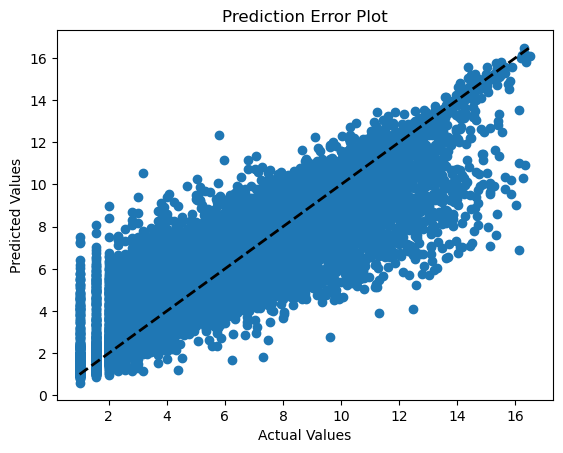

In [10]:
plt.scatter(best_actuals, best_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Error Plot")
plt.plot([best_actuals.min(), best_actuals.max()], [best_actuals.min(), best_actuals.max()], 'k--', lw=2)
plt.show()

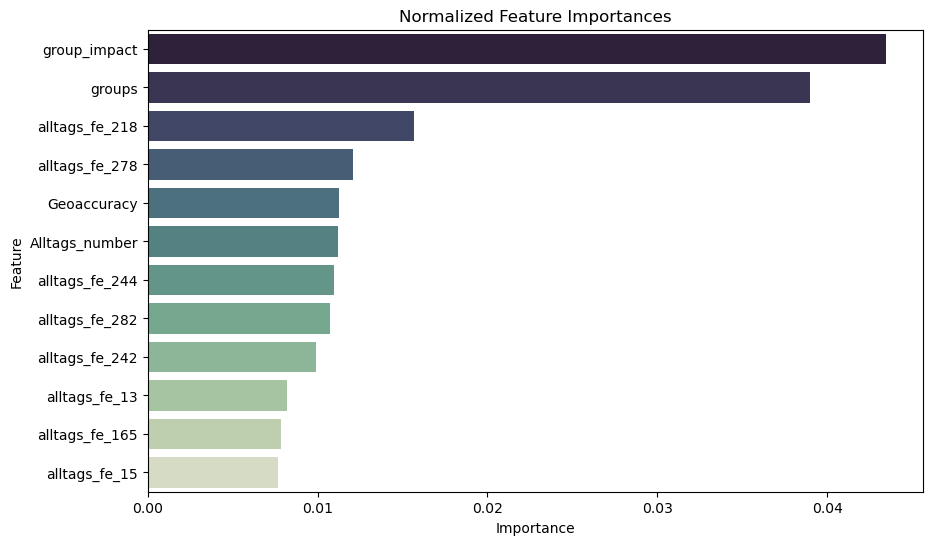

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb

# Extract feature importances from XGBoost model
feature_importances = best_model.get_score(importance_type='gain')

# XGBoost gives feature importance as a dictionary. Convert it to a list and normalize
features = list(feature_importances.keys())
importances = list(feature_importances.values())
normalized_importances = [i / sum(importances) for i in importances]

# Create a DataFrame for easy plotting
df_feature_importances = pd.DataFrame({'Feature': features, 'Importance': normalized_importances})

# Sort the DataFrame by importance
df_feature_importances = df_feature_importances.sort_values('Importance', ascending=False).head(12)

# Plot using a color palette that reflects importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_feature_importances, 
            palette=sns.cubehelix_palette(n_colors=12, start=.5, rot=-.75, reverse=True))
plt.title('Normalized Feature Importances')
plt.show()

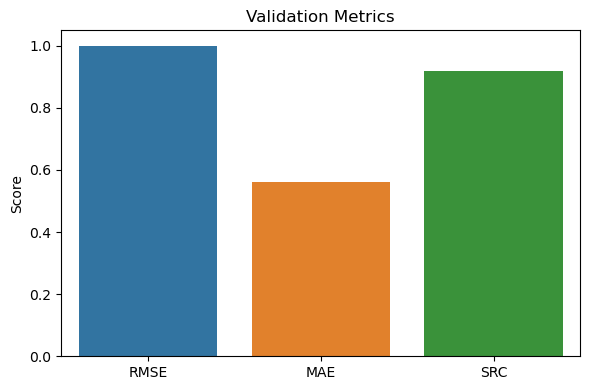

In [12]:
validation_metrics = np.array(valid_ans)  # Convert valid_ans to a numpy array

metrics = ['RMSE', 'MAE', 'SRC']
plt.figure(figsize=(6, 4))

# Plotting the metrics
sns.barplot(x=metrics, y=validation_metrics)
plt.title('Validation Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

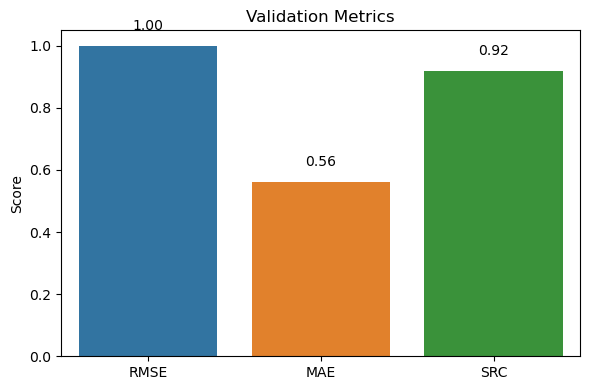

In [13]:
validation_metrics = np.array(valid_ans)  # Convert valid_ans to a numpy array

# Plotting the metrics
plt.figure(figsize=(6, 4))
sns.barplot(x=metrics, y=validation_metrics)
plt.title('Validation Metrics')
plt.ylabel('Score')

# Adding exact values on top of the bars
for i, v in enumerate(validation_metrics):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

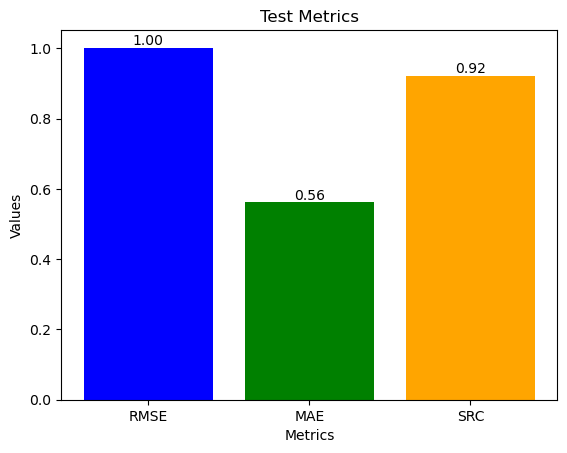

In [18]:
metrics = [test_rmse, test_mae, test_src]
labels = ['RMSE', 'MAE', 'SRC']

# Create a bar plot
plt.bar(labels, metrics, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Metrics')

# Display the values on top of the bars
for i, value in enumerate(metrics):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()

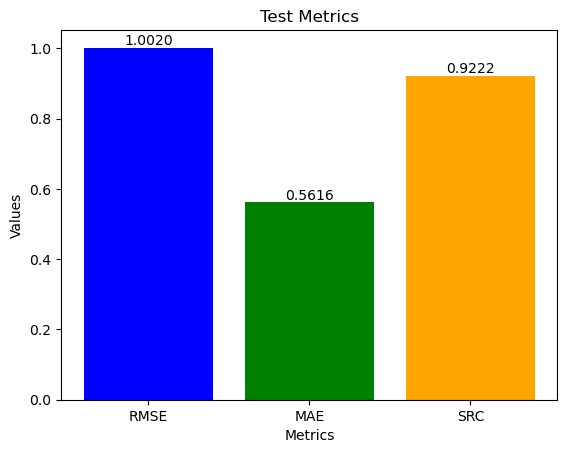

In [14]:
metrics = [1.0020, 0.5616, 0.9222]
labels = ['RMSE', 'MAE', 'SRC']

# Create a bar plot
plt.bar(labels, metrics, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Metrics')

# Display the values on top of the bars
for i, value in enumerate(metrics):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom')

# Show the plot
plt.show()

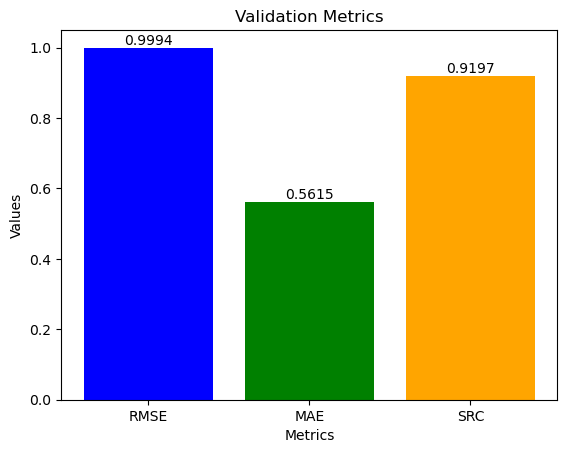

In [15]:
metrics = [0.9994, 0.5615, 0.9197]
labels = ['RMSE', 'MAE', 'SRC']

# Create a bar plot
plt.bar(labels, metrics, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Validation Metrics')

# Display the values on top of the bars
for i, value in enumerate(metrics):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom')

# Show the plot
plt.show()